In [70]:
from Bio import SeqIO
import pandas as pd
import numpy as np

from genominterv.remapping import remap
from genominterv.remapping import interval_distance, genomic
from genominterv.remapping import remap_interval_data
import seaborn as sns

### functions that kasper made to use to hamdel the compartment edges

In [71]:
def parse_compartment_data(file_name):
    e1_100kb = pd.read_csv(file_name)

       
    # remove na (experiment)
    e1_100kb.dropna(inplace=True)
    
    e1_100kb['start'] = [i*100_000 for i in range(e1_100kb.index.size)]
    e1_100kb['end'] = e1_100kb.start + 100_000
    e1_100kb['sign'] = np.sign(e1_100kb.e1)
    e1_100kb['segment_id'] = ((e1_100kb.sign.shift() != e1_100kb.sign)).cumsum()
    
    comp = e1_100kb.groupby('segment_id', as_index=False).agg(dict(
         e1=['mean', 'sum'], 
         start='min', 
         end='max', 
         segment_id='mean', 
         sign='mean'
    ))
    comp.columns = ['_'.join(col).strip() for col in comp.columns.values]
    comp = comp.rename(
        columns={'start_min':'start',
                 'end_max':'end', 
                 'segment_id_mean':'segment_id', 
                 'sign_mean':'sign'}
    )
    comp['comp'] = ['A' if x > 0 else 'B' for x in comp.sign]
    comp = comp.reset_index()
    comp['chrom'] = 'chrX'
    
    _comp = comp.copy()
    for i in range(1, _comp.index.size-1):
        if np.isnan(_comp.loc[i-1, 'e1_mean']):
            _comp.loc[i, 'start'] = np.nan
        if np.isnan(_comp.loc[i+1, 'e1_mean']):
            _comp.loc[i, 'end'] = np.nan
    _comp = _comp.loc[~_comp.e1_mean.isnull(), :]
    _comp = _comp.reset_index()
    compartment_edges = pd.concat([_comp.start, _comp.end]).sort_values().unique()
    
    compartments = comp.loc[~comp.e1_mean.isnull()].copy()
    compartments['start'] = compartments.start.astype(int)
    compartments['end'] = compartments.end.astype(int)

    return compartments, compartment_edges

def edge_segments(compartment_edges, flank):
    compartment_edge_segm = pd.DataFrame(np.column_stack((compartment_edges, compartment_edges+flank)), columns=['start', 'end'])
    compartment_edge_segm['chrom'] = 'chrX'
    return compartment_edge_segm

### loading the 5 eigentracks 

In [72]:
import os

# Load data
eigentrack_dir = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/eigentracks"
eigentrack_files = [
    f for f in os.listdir(eigentrack_dir) if f.endswith("_10Mb.csv")
]

comps_dict = {}
edges_dict = {}
generated_comps=[]
generated_edges=[]
a_and_b_comps = []

for filename in eigentrack_files:
    filepath = os.path.join(eigentrack_dir, filename)
    base = os.path.splitext(filename)[0]
    comps_var = f"{base}_comps"
    edges_var = f"{base}_edges"
    comps, edges = parse_compartment_data(filepath)
    comps_dict[comps_var] = comps
    edges_dict[edges_var] = edges
    generated_comps.append(comps_var)
    generated_edges.append(edges_var)

print("Generated variable names:", generated_comps)
print("Generated variable names:", generated_edges)

for edge_var in generated_edges:
    # Get the numpy array of edges from the dictionary
    edges = edges_dict[edge_var]
    
    # Create the DataFrame using edge_segments with flank=1
    seg_name = f"{edge_var}_interval"
    seg_df = edge_segments(edges, 1)
    #print(f"Created: {seg_name}")

    # Merge compartment assignment
    comps_var = edge_var.replace("_edges", "_comps")
    if comps_var in comps_dict:
        comps_df = comps_dict[comps_var]
        
        comp_df = pd.DataFrame({
            'comp': comps_df['comp'].reset_index(drop=True),
            'start': seg_df['start'].reset_index(drop=True),
            'end': seg_df['end'].reset_index(drop=True),
            'chrom': seg_df['chrom'].reset_index(drop=True)
        })

        # Save full merged comp_df
        comp_full_name = f"{edge_var}_interval_comp"
            # Save combined A and B compartments
        comp_AB_name = f"{edge_var}_AB"
        globals()[comp_AB_name] = comp_df
        a_and_b_comps.append(comp_AB_name)

        #print(f"Created: {comp_full_name}")

        # Split into compartments A and B
        comp_A = comp_df[comp_df['comp'] == 'A'].reset_index(drop=True)
        comp_B = comp_df[comp_df['comp'] == 'B'].reset_index(drop=True)

        # Save A and B splits as new variables
        comp_A_name = f"{edge_var}_A"
        comp_B_name = f"{edge_var}_B"
        globals()[comp_A_name] = comp_A
        globals()[comp_B_name] = comp_B
        a_and_b_comps.append(comp_A_name)
        a_and_b_comps.append(comp_B_name)
        
        #print(f"Created: {edge_var}_A and {edge_var}_B")

print("Generated compartment A and B variables:", a_and_b_comps)

#print(sperm_e1_100kb_10Mb_edges_A.head())

print(globals()[comp_AB_name].head())


Generated variable names: ['sperm_e1_100kb_10Mb_comps', 'round_spermatid_e1_100kb_10Mb_comps', 'pachytene_spermatocyte_e1_100kb_10Mb_comps', 'spermatogonia_e1_100kb_10Mb_comps', 'fibroblast_e1_100kb_10Mb_comps']
Generated variable names: ['sperm_e1_100kb_10Mb_edges', 'round_spermatid_e1_100kb_10Mb_edges', 'pachytene_spermatocyte_e1_100kb_10Mb_edges', 'spermatogonia_e1_100kb_10Mb_edges', 'fibroblast_e1_100kb_10Mb_edges']
Generated compartment A and B variables: ['sperm_e1_100kb_10Mb_edges_AB', 'sperm_e1_100kb_10Mb_edges_A', 'sperm_e1_100kb_10Mb_edges_B', 'round_spermatid_e1_100kb_10Mb_edges_AB', 'round_spermatid_e1_100kb_10Mb_edges_A', 'round_spermatid_e1_100kb_10Mb_edges_B', 'pachytene_spermatocyte_e1_100kb_10Mb_edges_AB', 'pachytene_spermatocyte_e1_100kb_10Mb_edges_A', 'pachytene_spermatocyte_e1_100kb_10Mb_edges_B', 'spermatogonia_e1_100kb_10Mb_edges_AB', 'spermatogonia_e1_100kb_10Mb_edges_A', 'spermatogonia_e1_100kb_10Mb_edges_B', 'fibroblast_e1_100kb_10Mb_edges_AB', 'fibroblast_e1_1

## Load file fasta fiel

In [73]:
columns = [
    "bin", "chrom", "chromStart", "chromEnd", "name", "score", "strand",
    "thickStart", "thickEnd", "reserved", "blockCount", "blockSizes",
    "chromStarts", "strandRep", "repLeft", "repClass", "repFamily"
]

simple_repeats =pd.read_csv("../data/simpleRepeat.txt", sep='\t', header=None, names=columns)
simple_repeats = simple_repeats[simple_repeats['chrom'] == 'chrX']
print(simple_repeats.head(10))
df_simple_repeats = simple_repeats[['chrom', 'chromStart', 'chromEnd']].rename(
    columns={'chromStart': 'start', 'chromEnd': 'end'}
)
print(simple_repeats['repFamily'].unique().shape)

        bin chrom  chromStart  chromEnd name  score  strand  thickStart  \
935331  585  chrX        1329      1368  trf     20     1.9          20   
935332  585  chrX        4721      4765  trf     16     2.8          16   
935333  585  chrX        4722      5839  trf    354     3.1         361   
935334  585  chrX        4767      4806  trf     20     2.0          20   
935335  585  chrX        4783      4826  trf     16     2.7          16   
935336  585  chrX        4789      4937  trf      4    37.2           4   
935337  585  chrX        4857      4905  trf     19     2.5          20   
935338  585  chrX        5057      5127  trf     32     2.2          32   
935339  585  chrX        5073      5883  trf      4   203.8           4   
935340  585  chrX        5788      6005  trf     20    11.1          20   

        thickEnd  reserved  blockCount  blockSizes  chromStarts  strandRep  \
935331        89         5          60          79            0         15   
935332        78  

In [74]:
for edge_var in generated_edges:
    comp_AB_name = f"{edge_var}_AB"
    if comp_AB_name in globals():
        print(f"Head of {comp_AB_name}:")
        print(globals()[comp_AB_name].head())
        print()



Head of sperm_e1_100kb_10Mb_edges_AB:
  comp    start      end chrom
0    A        0        1  chrX
1    B  1700000  1700001  chrX
2    A  7500000  7500001  chrX
3    B  9000000  9000001  chrX
4    A  9200000  9200001  chrX

Head of round_spermatid_e1_100kb_10Mb_edges_AB:
  comp    start      end chrom
0    A        0        1  chrX
1    B  1200000  1200001  chrX
2    A  6700000  6700001  chrX
3    B  6800000  6800001  chrX
4    A  7200000  7200001  chrX

Head of pachytene_spermatocyte_e1_100kb_10Mb_edges_AB:
  comp    start      end chrom
0    A        0        1  chrX
1    B  1100000  1100001  chrX
2    A  7700000  7700001  chrX
3    B  7800000  7800001  chrX
4    A  8500000  8500001  chrX

Head of spermatogonia_e1_100kb_10Mb_edges_AB:
  comp    start      end chrom
0    A        0        1  chrX
1    B  1100000  1100001  chrX
2    A  8400000  8400001  chrX
3    B  8700000  8700001  chrX
4    A  8800000  8800001  chrX

Head of fibroblast_e1_100kb_10Mb_edges_AB:
  comp     start      

In [75]:
import numpy as np
import pandas as pd
from genominterv.remapping import remap_interval_data




def plot_repeat_density_vs_compartment_edge(df_repeats, df_compartment_anchors):
    """
    Remaps repeat intervals to a compartment coordinate space and returns the
    A-value and B-value groups based on signed distance logic.

    Parameters:
    - df_repeats: DataFrame of genomic intervals to remap (must have chrom/start/end).
    - df_compartment_anchors: DataFrame with compartment structure (must have chrom/start/end/comp).

    Returns:
    - A_val: DataFrame for Compartment A-assigned intervals
    - B_val: DataFrame for Compartment B-assigned intervals
    """

    # Clean and sort
    sperm_clean = df_compartment_anchors.dropna(subset=["start", "end"]).copy()
    sperm_clean["start"] = sperm_clean["start"].astype(int)
    sperm_clean["end"] = sperm_clean["end"].astype(int)
    df_repeats = df_repeats.dropna(subset=["start", "end"]).copy()
    df_repeats["start"] = df_repeats["start"].astype(int)
    df_repeats["end"] = df_repeats["end"].astype(int)

    # Sort
    sperm_clean = sperm_clean.sort_values(by=['chrom', 'start', 'end'])
    df_repeats = df_repeats.sort_values(by=['chrom', 'start', 'end'])

    # Remap
    result = remap_interval_data(df_repeats, sperm_clean, include_prox_coord=True)

    # Post-process
    result["mid"] = (result["start"] + result["end"]) / 2
    result["absmid"] = result["mid"].abs()
    for col in ["start", "end", "mid", "absmid"]:
        result[col] = result[col].replace([0.0, -0.0], np.nan)
    result = result.dropna(subset=["start", "end", "mid", "absmid", "start_prox", "end_prox"], how="any")

    # Map compartment identity
    start_to_comp = sperm_clean.drop_duplicates(subset=["start"]).set_index("start")["comp"]
    result["comp"] = result["start_prox"].map(start_to_comp)

    # Split into A and B groups based on signed start
    A_val = result[
        ((result['comp'] == 'A') & (result['start'] < 0)) |
        ((result['comp'] == 'B') & (result['start'] > 0))
    ].copy()
    B_val = result[
        ((result['comp'] == 'A') & (result['start'] > 0)) |
        ((result['comp'] == 'B') & (result['start'] < 0))
    ].copy()

    # Add abs start and label
    A_val['abs_start'] = A_val['start'].abs()
    B_val['abs_start'] = B_val['start'].abs()
    A_val['group'] = 'Compartment A'
    B_val['group'] = 'Compartment B'

    return A_val, B_val

A_val, B_val = plot_repeat_density_vs_compartment_edge( df_simple_repeats, sperm_e1_100kb_10Mb_edges_AB)
print(A_val.head())
print(B_val.head())

      start     end  start_prox   end_prox chrom  start_orig  end_orig  \
2933    104   244.0   1700000.0  1700001.0  chrX     1700105   1700245   
2934    120   270.0   1700000.0  1700001.0  chrX     1700121   1700271   
2935   4145  4204.0   1700000.0  1700001.0  chrX     1704146   1704205   
2936   4156  4199.0   1700000.0  1700001.0  chrX     1704157   1704200   
2937   4167  4205.0   1700000.0  1700001.0  chrX     1704168   1704206   

         mid  absmid comp  abs_start          group  
2933   174.0   174.0    B        104  Compartment A  
2934   195.0   195.0    B        120  Compartment A  
2935  4174.5  4174.5    B       4145  Compartment A  
2936  4177.5  4177.5    B       4156  Compartment A  
2937  4186.0  4186.0    B       4167  Compartment A  
   start     end  start_prox  end_prox chrom  start_orig  end_orig     mid  \
0   1328  1367.0         0.0       1.0  chrX        1329      1368  1347.5   
1   4720  4764.0         0.0       1.0  chrX        4721      4765  4742.0 

### backup

In [76]:
# Instead of relying on globals(), define your input list explicitly
input_list = [
    ("sperm_e1_100kb_10Mb_edges_AB", sperm_e1_100kb_10Mb_edges_AB),
    ("round_spermatid_e1_100kb_10Mb_edges_AB", round_spermatid_e1_100kb_10Mb_edges_AB),
    ("pachytene_spermatocyte_e1_100kb_10Mb_edges_AB", pachytene_spermatocyte_e1_100kb_10Mb_edges_AB),
    ("spermatogonia_e1_100kb_10Mb_edges_AB", spermatogonia_e1_100kb_10Mb_edges_AB),
    ("fibroblast_e1_100kb_10Mb_edges_AB", fibroblast_e1_100kb_10Mb_edges_AB),
]

# Dictionary to hold results
remapped_simple_filter_data_chrx = {}

# Loop through the list instead of globals
for name, df_anchor in input_list:
    print(f"\nRunning on: {name}")
    try:
        A_value, B_value = plot_repeat_density_vs_compartment_edge(df_simple_repeats, df_anchor)
        
        # Store in dictionary with cleaner key (strip _AB)
        remapped_simple_filter_data_chrx[name.replace('_AB', '')] = {
            "A": A_value,
            "B": B_value
        }
        
        print(f" A_value: {A_value.shape}, B_value: {B_value.shape}")
    except Exception as e:
        print(f" ❌ Failed on {name}: {e}")



Running on: sperm_e1_100kb_10Mb_edges_AB
 A_value: (31454, 12), B_value: (19520, 12)

Running on: round_spermatid_e1_100kb_10Mb_edges_AB
 A_value: (30334, 12), B_value: (19423, 12)

Running on: pachytene_spermatocyte_e1_100kb_10Mb_edges_AB
 A_value: (26647, 12), B_value: (21233, 12)

Running on: spermatogonia_e1_100kb_10Mb_edges_AB
 A_value: (29519, 12), B_value: (19739, 12)

Running on: fibroblast_e1_100kb_10Mb_edges_AB
 A_value: (29748, 12), B_value: (22042, 12)


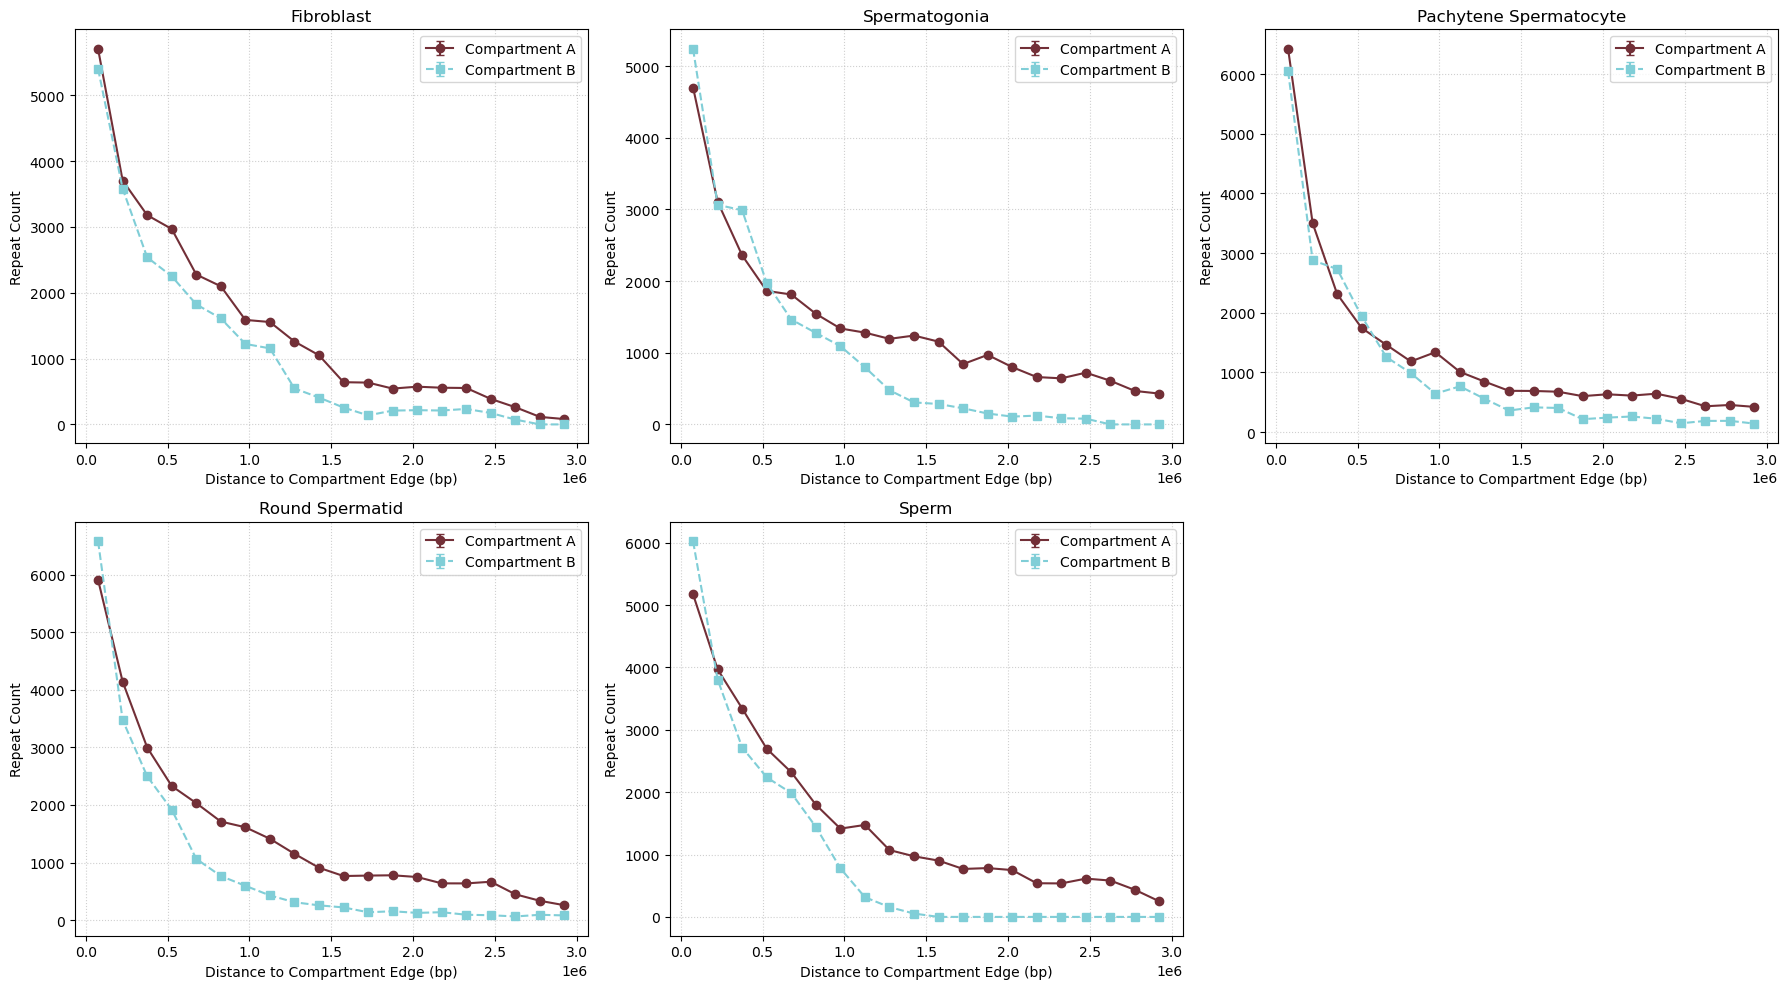

In [77]:
import numpy as np
import matplotlib.pyplot as plt

A_color = "#722F37"  # Indigo
B_color = "#80CED7"  # Coral

# Desired order
order = [
    "fibroblast_e1_100kb_10Mb_edges",
    "spermatogonia_e1_100kb_10Mb_edges",
    "pachytene_spermatocyte_e1_100kb_10Mb_edges",
    "round_spermatid_e1_100kb_10Mb_edges",
    "sperm_e1_100kb_10Mb_edges",
]

# Plot settings
num_bins = 20
max_dist = 3_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def bin_half_distances_by_compartment(comp, max_dist, n_bins):
    """
    Bin half-distances between consecutive 'start' positions,
    ignoring compartments (A/B). Return forward & reverse cumulative stats.
    """
    bin_edges = np.linspace(0, max_dist, n_bins + 1)
    start = comp['start'].values

    if len(start) < 2:
        counts = np.zeros(n_bins, dtype=int)
    else:
        half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]
        counts, _ = np.histogram(half_distances, bins=bin_edges)

    total = counts.sum()
    if total > 0:
        cumulative_fraction = np.cumsum(counts) / total
        reverse_cumulative_fraction = np.cumsum(counts[::-1])[::-1] / total
    else:
        cumulative_fraction = np.zeros(n_bins, dtype=float)
        reverse_cumulative_fraction = np.zeros(n_bins, dtype=float)

    reverse_cumulative = np.cumsum(counts[::-1])[::-1]

    return {
        "counts": counts,
        "cumulative_fraction": cumulative_fraction,
        "reverse_cumulative_fraction": reverse_cumulative_fraction,
        "reverse_cumulative": reverse_cumulative
    }

def bin_absmid_with_error(absmid_values, bin_edges, reverse_cumulative):
    """
    Symmetric 95% CI using SD = sqrt(count / n_possible),
    where n_possible = reverse_cumulative (>=1).
    """
    counts, _ = np.histogram(absmid_values, bins=bin_edges)
    n_possible = np.maximum(reverse_cumulative.astype(float), 1.0)

    with np.errstate(divide='ignore', invalid='ignore'):
        errors = np.sqrt(counts.astype(float) / n_possible)
        errors[np.isnan(errors)] = 0.0

    return counts, 1.96 * errors  # ~95% CI

# Prepare plot grid (2 rows x 3 cols)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = np.array(axes).flatten()

plot_idx = 0
for sample in order:
    if sample not in remapped_simple_filter_data_chrx:
        print(f"Warning: {sample} not found in remapped_simple_filter_data, skipping...")
        continue
    if plot_idx >= len(axes):
        break

    # --- per-sample reverse_cumulative ---
    edge_key = f"{sample}_AB"
    if edge_key not in globals():
        print(f"Warning: {edge_key} not found in globals(), skipping...")
        continue
    edge_df = globals()[edge_key]
    result = bin_half_distances_by_compartment(edge_df, max_dist=max_dist, n_bins=num_bins)

    pair = remapped_simple_filter_data_chrx[sample]
    A_df = pair["A"]
    B_df = pair["B"]

    counts_A, errors_A = bin_absmid_with_error(
        A_df['absmid'].dropna().values, bins, result["reverse_cumulative"]
    )
    counts_B, errors_B = bin_absmid_with_error(
        B_df['absmid'].dropna().values, bins, result["reverse_cumulative"]
    )

    ax = axes[plot_idx]
    ax.errorbar(
        bin_centers, counts_A, yerr=errors_A, marker='o', linestyle='-',
        capsize=3, label='Compartment A', color=A_color
    )
    ax.errorbar(
        bin_centers, counts_B, yerr=errors_B, marker='s', linestyle='--',
        capsize=3, label='Compartment B', color=B_color
    )

    clean_title = sample.replace("_e1_100kb_10Mb_edges", "").replace("_", " ").title()
    ax.set_title(clean_title)
    ax.set_xlabel("Distance to Compartment Edge (bp)")
    ax.set_ylabel("Repeat Count")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend()

    plot_idx += 1

# Hide unused axes
for i in range(plot_idx, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.savefig(
    "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/manuscript/illustrations/simple_repeat/simple_repeat_chrx_not_normalized.png",
    dpi=300
)
plt.show()


# AB or BA

In [78]:
def remapping_no_filter_compartment(df_repeats, df_compartment_anchors):
    """
    Remaps repeats to compartment edges and groups only by target compartment identity,
    ignoring directionality. Returns absolute distances for plotting.

    Parameters:
    - df_repeats: DataFrame with columns chrom, start, end
    - df_compartment_anchors: DataFrame with columns chrom, start, end, comp

    Returns:
    - A_val: DataFrame of repeats near compartment A
    - B_val: DataFrame of repeats near compartment B
    """
    # Clean and sort
    anchors = df_compartment_anchors.dropna(subset=["start", "end"]).copy()
    anchors["start"] = anchors["start"].astype(int)
    anchors["end"] = anchors["end"].astype(int)
    df_repeats = df_repeats.dropna(subset=["start", "end"]).copy()
    df_repeats["start"] = df_repeats["start"].astype(int)
    df_repeats["end"] = df_repeats["end"].astype(int)

    anchors = anchors.sort_values(by=['chrom', 'start', 'end'])
    df_repeats = df_repeats.sort_values(by=['chrom', 'start', 'end'])

    # Remap
    result = remap_interval_data(df_repeats, anchors, include_prox_coord=True)

    # Post-process
    result["mid"] = (result["start"] + result["end"]) / 2
    result["absmid"] = result["mid"].abs()
    result = result.dropna(subset=["start", "end", "mid", "absmid", "start_prox", "end_prox"], how="any")

    # Map compartment identity
    start_to_comp = anchors.drop_duplicates(subset=["start"]).set_index("start")["comp"]
    result["comp"] = result["start_prox"].map(start_to_comp)

    # Split only based on target compartment (ignore direction)
    A_val = result[result['comp'] == 'A'].copy()
    B_val = result[result['comp'] == 'B'].copy()

    A_val["abs_start"] = A_val["start"].abs()
    B_val["abs_start"] = B_val["start"].abs()
    A_val["group"] = "Compartment A"
    B_val["group"] = "Compartment B"

    return A_val, B_val

In [79]:
# Explicit list of (name, DataFrame) tuples
input_list = [
    ("sperm_e1_100kb_10Mb_edges_AB", sperm_e1_100kb_10Mb_edges_AB),
    ("round_spermatid_e1_100kb_10Mb_edges_AB", round_spermatid_e1_100kb_10Mb_edges_AB),
    ("pachytene_spermatocyte_e1_100kb_10Mb_edges_AB", pachytene_spermatocyte_e1_100kb_10Mb_edges_AB),
    ("spermatogonia_e1_100kb_10Mb_edges_AB", spermatogonia_e1_100kb_10Mb_edges_AB),
    ("fibroblast_e1_100kb_10Mb_edges_AB", fibroblast_e1_100kb_10Mb_edges_AB),
]

# Dictionary for storing results
remapped_data_chrx = {}

# Loop and run your function
for name, df_anchor in input_list:
    print(f"\nRunning on: {name}")
    try:
        A_value, B_value = remapping_no_filter_compartment(df_simple_repeats, df_anchor)

        remapped_data_chrx[name.replace('_AB', '')] = {
            "A": A_value,
            "B": B_value
        }

        print(f"  A_value: {A_value.shape}, B_value: {B_value.shape}")
    except Exception as e:
        print(f"  ❌ Failed on {name}: {e}")



Running on: sperm_e1_100kb_10Mb_edges_AB
  A_value: (24406, 12), B_value: (26568, 12)

Running on: round_spermatid_e1_100kb_10Mb_edges_AB


  A_value: (24029, 12), B_value: (25728, 12)

Running on: pachytene_spermatocyte_e1_100kb_10Mb_edges_AB
  A_value: (23290, 12), B_value: (24590, 12)

Running on: spermatogonia_e1_100kb_10Mb_edges_AB
  A_value: (23278, 12), B_value: (25980, 12)

Running on: fibroblast_e1_100kb_10Mb_edges_AB
  A_value: (25282, 12), B_value: (26508, 12)


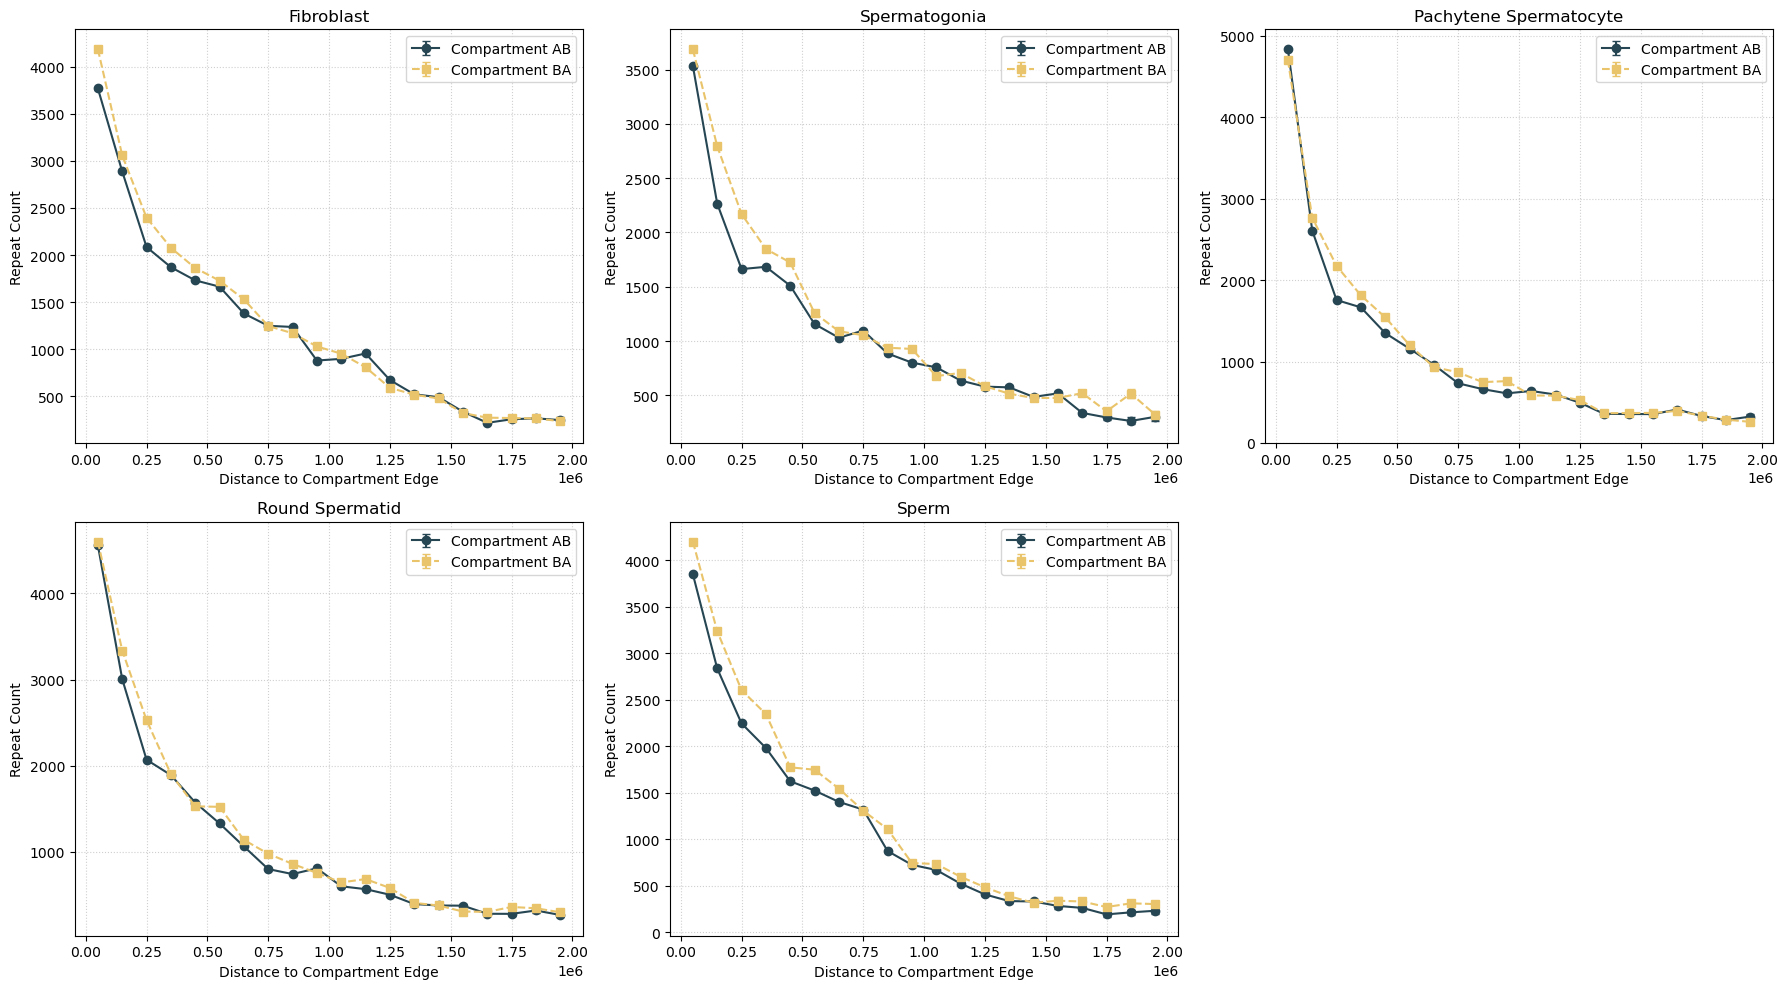

In [80]:
import numpy as np
import matplotlib.pyplot as plt

A_color = "#264653"  # Indigo
B_color = "#E9C46A"  # Coral

# Desired order (keys in remapped_data)
order = [
    "fibroblast_e1_100kb_10Mb_edges",
    "spermatogonia_e1_100kb_10Mb_edges",
    "pachytene_spermatocyte_e1_100kb_10Mb_edges",
    "round_spermatid_e1_100kb_10Mb_edges",
    "sperm_e1_100kb_10Mb_edges",
]

# Plot settings
num_bins = 20
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def bin_half_distances_by_compartment(comp, max_dist=2_000_000, bins=num_bins):
    """
    Bin half-distances between consecutive 'start' positions,
    ignoring compartments (A/B) and returning a single result
    with both forward and reverse cumulative fractions.
    """
    bin_edges = np.linspace(0, max_dist, bins + 1)

    start = comp['start'].values
    if len(start) < 2:
        counts = np.zeros(bins, dtype=int)
    else:
        half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]
        counts, _ = np.histogram(half_distances, bins=bin_edges)

    total = np.sum(counts)
    if total > 0:
        cumulative_fraction = np.cumsum(counts) / total
        reverse_cumulative_fraction = np.cumsum(counts[::-1])[::-1] / total
    else:
        cumulative_fraction = np.zeros(bins)
        reverse_cumulative_fraction = np.zeros(bins)

    reverse_cumulative = np.cumsum(counts[::-1])[::-1]

    return {
        "counts": counts,
        "cumulative_fraction": cumulative_fraction,
        "reverse_cumulative_fraction": reverse_cumulative_fraction,
        "reverse_cumulative": reverse_cumulative
    }

def bin_absmid_with_error(absmid_values, bins, reverse_cumulative):
    """
    Calculate counts and symmetric error bars using
    SD = sqrt(count / n_possible), where n_possible = reverse_cumulative.
    """
    counts, _ = np.histogram(absmid_values, bins=bins)

    with np.errstate(divide='ignore', invalid='ignore'):
        errors = np.sqrt(counts / np.maximum(reverse_cumulative, 1))
        errors[np.isnan(errors)] = 0.0

    return counts, 1.96 * errors  # 95% CI

# Layout (2x3 fits up to 6)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = np.array(axes).flatten()

# Only keep samples that exist
present = [s for s in order if s in remapped_data_chrx]

plot_idx = 0
for sample in present:
    if plot_idx >= len(axes):
        break  # safety

    # --- compute reverse_cumulative PER SAMPLE from that sample's edge dataframe ---
    edge_key = f"{sample}_AB"
    if edge_key not in globals():
        print(f"Warning: {edge_key} not found in globals(), skipping...")
        continue
    edge_df = globals()[edge_key]
    result = bin_half_distances_by_compartment(edge_df, max_dist=max_dist, bins=num_bins)

    pair = remapped_data_chrx[sample]
    A_df = pair["A"]
    B_df = pair["B"]

    counts_A, errors_A = bin_absmid_with_error(
        A_df['absmid'].dropna().values, bins, result["reverse_cumulative"]
    )
    counts_B, errors_B = bin_absmid_with_error(
        B_df['absmid'].dropna().values, bins, result["reverse_cumulative"]
    )

    ax = axes[plot_idx]
    ax.errorbar(bin_centers, counts_A, yerr=errors_A, marker='o', linestyle='-',
                capsize=3, label='Compartment AB', color=A_color)
    ax.errorbar(bin_centers, counts_B, yerr=errors_B, marker='s', linestyle='--',
                capsize=3, label='Compartment BA', color=B_color)

    clean_title = sample.replace("_e1_100kb_10Mb_edges", "").replace("_", " ").title()
    ax.set_title(clean_title)
    ax.set_xlabel("Distance to Compartment Edge")
    ax.set_ylabel("Repeat Count")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend()

    plot_idx += 1

# Hide unused subplots
for i in range(plot_idx, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## corrected plot

[0.20833333 0.4        0.54166667 0.59166667 0.66666667 0.69166667
 0.73333333 0.75833333 0.79166667 0.85833333 0.85833333 0.86666667
 0.9        0.91666667 0.93333333 0.975      0.98333333 0.98333333
 0.99166667 1.        ]
[25 23 17  6  9  3  5  3  4  8  0  1  4  2  2  5  1  0  1  1]
[120  95  72  55  49  40  37  32  29  25  17  17  16  12  10   8   3   2
   2   1]

Sample: fibroblast_e1_100kb_10Mb_edges
Counts A: [4063 3107 2235 2166 2079 1901 1616 1422 1336 1085 1086  971  893  704
  712  457  380  439  374  356]
Counts B: [3894 2839 2247 1782 1514 1491 1292 1072 1069  823  763  791  368  332
  254  200  109   84  155  125]

Sample: fibroblast_e1_100kb_10Mb_edges
Bin 1: 0–100000 bp | Count A = 4063, Count B = 3894, n_possible = 120
Bin 2: 100000–200000 bp | Count A = 3107, Count B = 2839, n_possible = 95
Bin 3: 200000–300000 bp | Count A = 2235, Count B = 2247, n_possible = 72
Bin 4: 300000–400000 bp | Count A = 2166, Count B = 1782, n_possible = 55
Bin 5: 400000–500000 bp | Count 

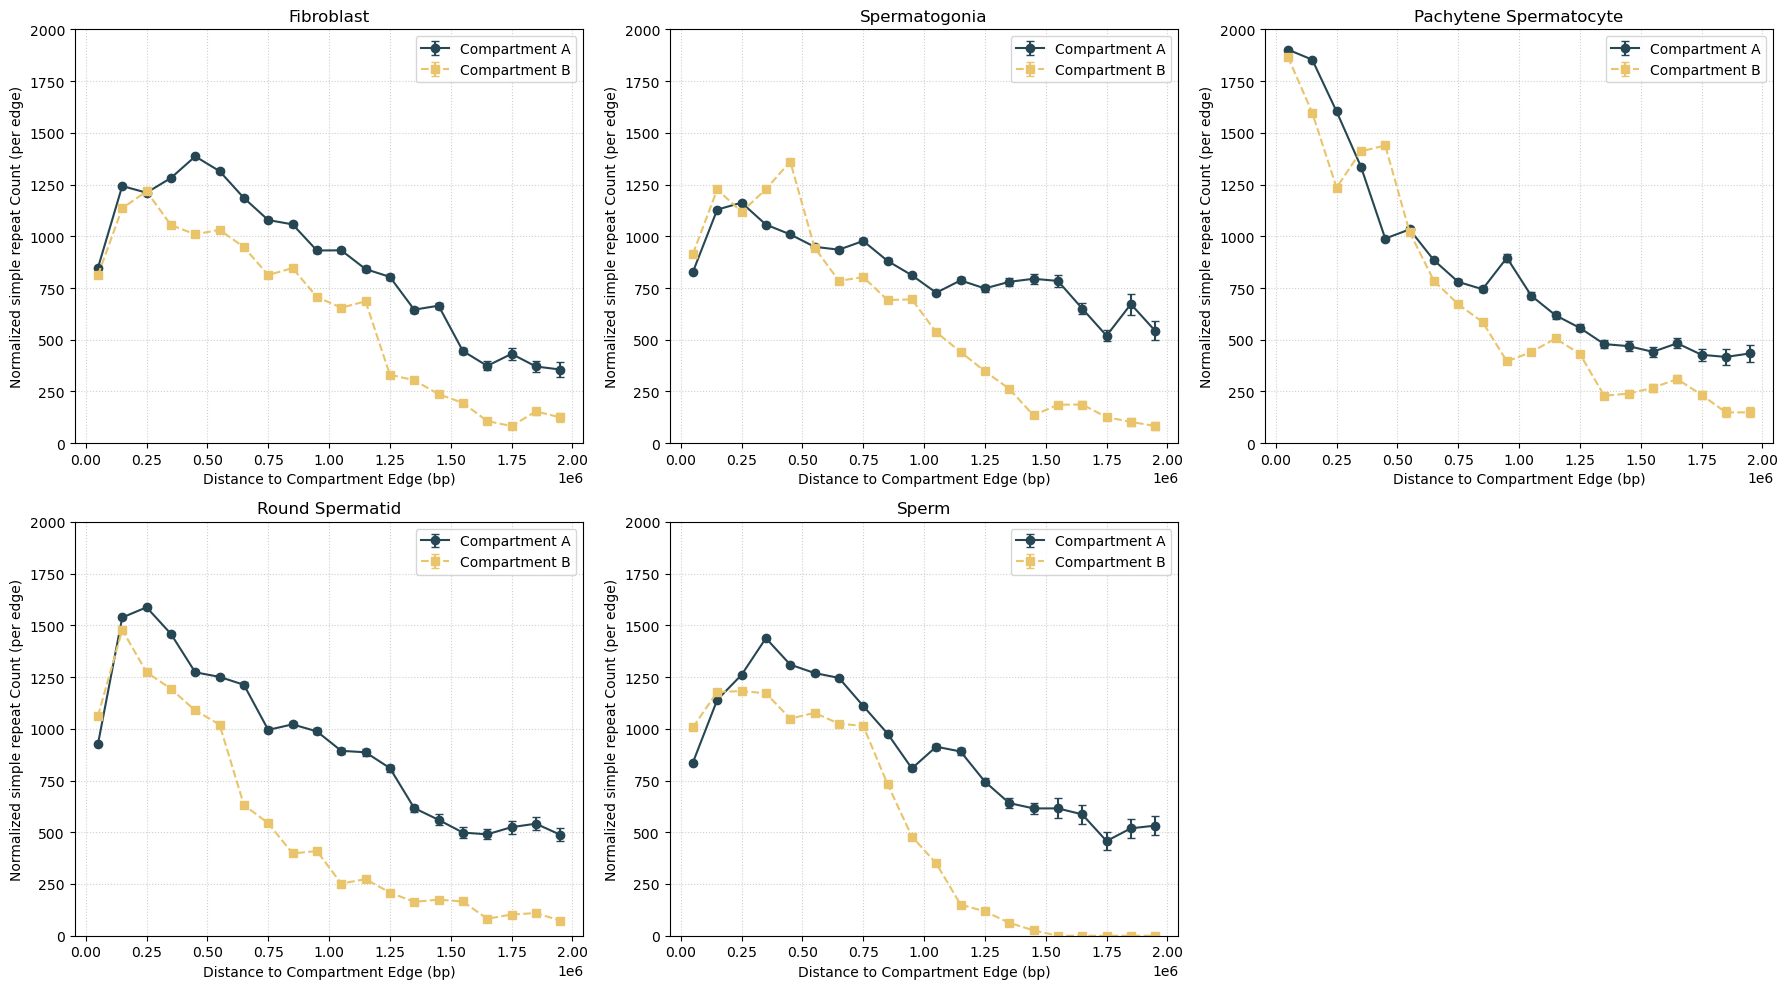

In [81]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

chr8_colors = {"A": "#2CA02C", "B": "#D62728"}   # Green / Red
chrx_colors = {"A": "#722F37", "B": "#80CED7"}   # Indigo / Coral
# Desired order
order = [
    "fibroblast_e1_100kb_10Mb_edges",
    "spermatogonia_e1_100kb_10Mb_edges",
    "pachytene_spermatocyte_e1_100kb_10Mb_edges",
    "round_spermatid_e1_100kb_10Mb_edges",
    "sperm_e1_100kb_10Mb_edges",
]

# Plot settings
num_bins = 20
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def bin_half_distances_by_compartment(comp, max_dist=2_000_000, bins=num_bins):
    """
    Bin half-distances between consecutive 'start' positions,
    ignoring compartments (A/B) and returning a single result
    with both forward and reverse cumulative fractions.
    """
    bin_edges = np.linspace(0, max_dist, bins + 1)

    start = comp['start'].values
    if len(start) < 2:
        counts = np.zeros(bins, dtype=int)
    else:
        half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]
        counts, _ = np.histogram(half_distances, bins=bin_edges)

    total = np.sum(counts)
    if total > 0:
        cumulative_fraction = np.cumsum(counts) / total
        reverse_cumulative_fraction = np.cumsum(counts[::-1])[::-1] / total
    else:
        cumulative_fraction = np.zeros(bins)
        reverse_cumulative_fraction = np.zeros(bins)

    reverse_cumulative = np.cumsum(counts[::-1])[::-1]

    result = {
        "counts": counts,
        "cumulative_fraction": cumulative_fraction,
        "reverse_cumulative_fraction": reverse_cumulative_fraction,
        "reverse_cumulative": reverse_cumulative
    }
    return result

# ONLY CHANGE: Updated error calculation to account for variable sample sizes
def bin_absmid_with_sd(absmid_values, bins, reverse_cumulative):
    """
    Calculate counts and symmetric error bars using
    SD = sqrt(count / n_possible), where n_possible = reverse_cumulative.
    """
    counts, _ = np.histogram(absmid_values, bins=bins)

    # Avoid divide-by-zero
    with np.errstate(divide='ignore', invalid='ignore'):
        errors = np.sqrt(counts / np.maximum(reverse_cumulative, 1))
        errors[np.isnan(errors)] = 0.0

    errors = 1.96 * errors  # 95% CI multiplier

    return counts, errors


# Prepare grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = np.array(axes).flatten()

plot_idx = 0
for sample in order:
    if sample not in remapped_simple_filter_data_chrx:
        print(f"⚠️ Warning: {sample} not found, skipping…")
        continue

    edge_key = f"{sample}_AB"
    if edge_key not in globals():
        print(f"⚠️ Warning: {edge_key} not found, skipping…")
        continue

    pair = remapped_simple_filter_data_chrx[sample]
    A_df = pair["A"]
    B_df = pair["B"]

    edge_df = globals()[edge_key]
    result = bin_half_distances_by_compartment(edge_df)

    
    # Use SD-based errors
    counts_A, errors_A = bin_absmid_with_sd(
        A_df['absmid'].dropna().values, bins, result["reverse_cumulative"]
    )
    counts_B, errors_B = bin_absmid_with_sd(
        B_df['absmid'].dropna().values, bins, result["reverse_cumulative"]
    )

    
    print(result["cumulative_fraction"])
    print(result["counts"])
    print(result["reverse_cumulative"])
        # 🔎 Print raw counts per bin (before normalization)
    print(f"\nSample: {sample}")
    print("Counts A:", counts_A)
    print("Counts B:", counts_B)
    print(f"\nSample: {sample}")
    for i in range(len(bins) - 1):
        print(f"Bin {i+1}: {bins[i]:.0f}–{bins[i+1]:.0f} bp | "
              f"Count A = {counts_A[i]}, Count B = {counts_B[i]}, "
              f"n_possible = {result['reverse_cumulative'][i]}")

    # Normalize counts (same as before)
    norm_cumulative_A = np.where(result["cumulative_fraction"] == 0, np.nan, result["cumulative_fraction"])
    norm_cumulative_B = np.where(result["cumulative_fraction"] == 0, np.nan, result["cumulative_fraction"])

    norm_counts_A = counts_A * norm_cumulative_A
    norm_counts_B = counts_B * norm_cumulative_B
    norm_errors_A = errors_A * norm_cumulative_A
    norm_errors_B = errors_B * norm_cumulative_B

    # Plot (EXACTLY THE SAME AS BEFORE)
    ax = axes[plot_idx]
    ax.errorbar(bin_centers, norm_counts_A, yerr=norm_errors_A, marker='o',
                linestyle='-', capsize=3, label='Compartment A', color=A_color)
    ax.errorbar(bin_centers, norm_counts_B, yerr=norm_errors_B, marker='s',
                linestyle='--', capsize=3, label='Compartment B', color=B_color)

    clean_title = sample.replace("_e1_100kb_10Mb_edges", "").replace("_", " ").title()
    ax.set_title(clean_title)
    ax.set_xlabel("Distance to Compartment Edge (bp)")
    ax.set_ylabel("Normalized simple repeat Count (per edge)")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend()
    ax.set_ylim(0, 2000)

    plot_idx += 1

# Hide unused panels
for i in range(plot_idx, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.savefig(
    "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/manuscript/illustrations/simple_repeat/simple_repeat_chrx_normalized_poisson_CI.png",
    dpi=300
)
plt.show()

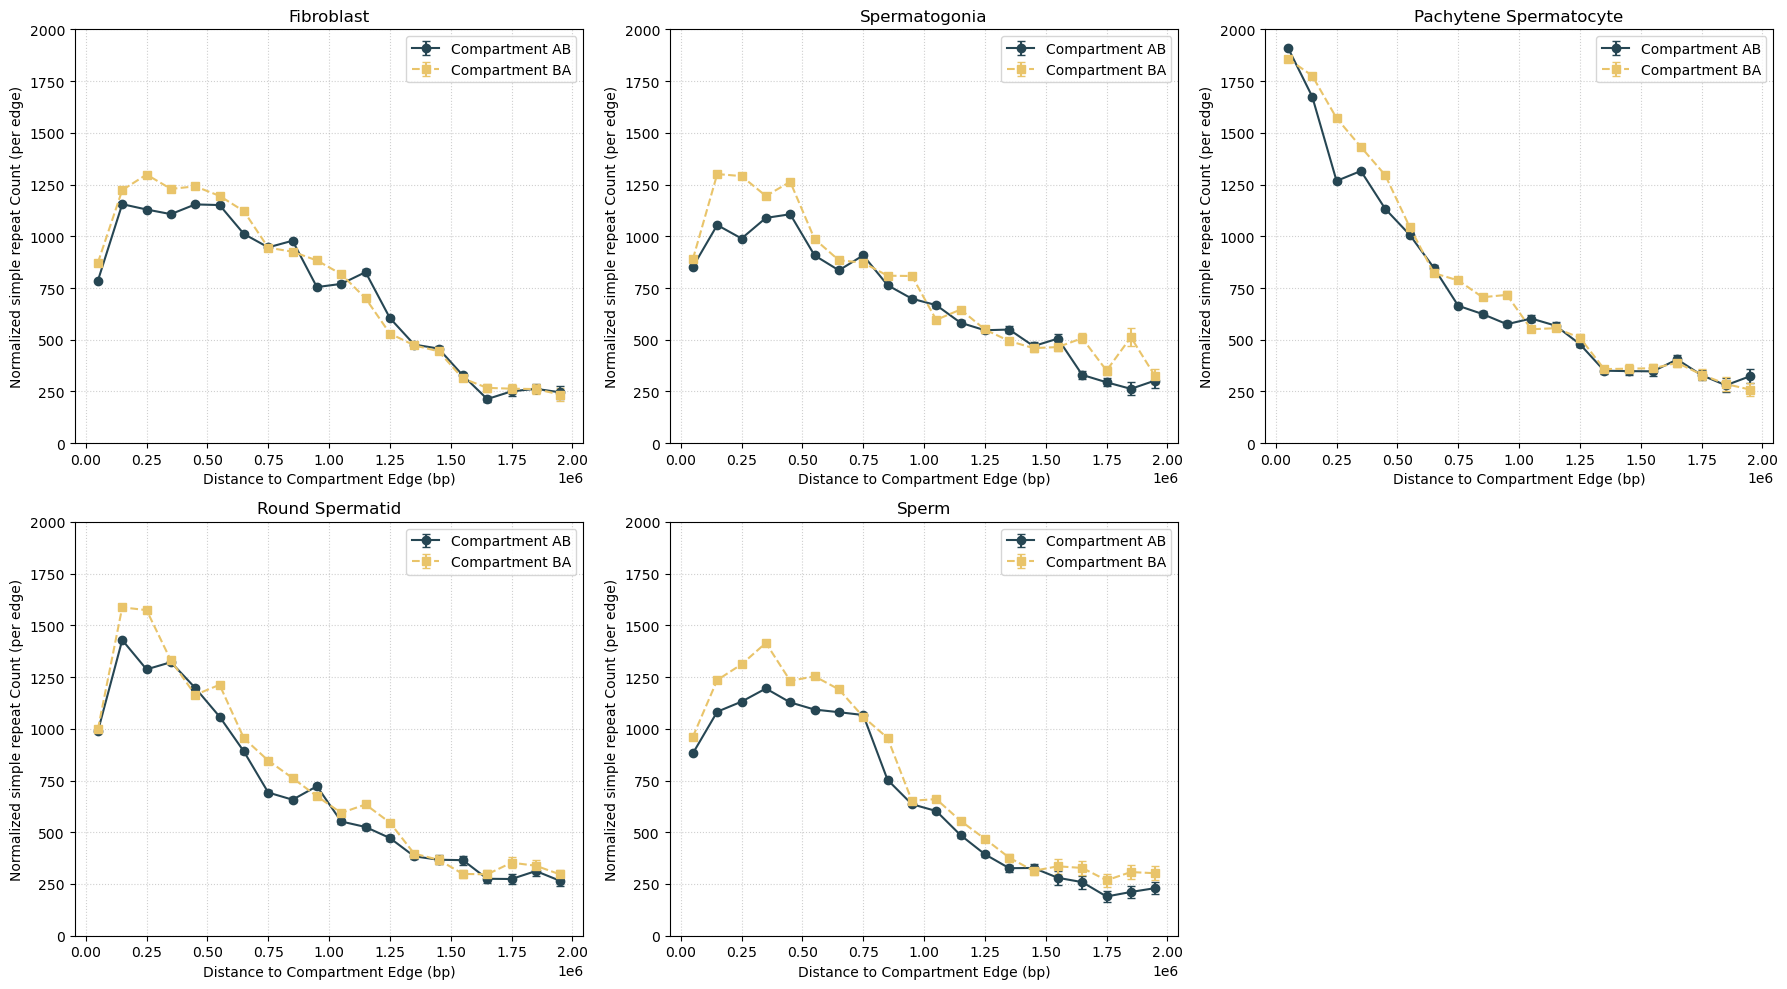

In [82]:
import numpy as np
import matplotlib.pyplot as plt

A_color = "#264653"  # Indigo
B_color = "#E9C46A"  # Coral

# Desired plotting order (must match keys in remapped_data)
order = [
    "fibroblast_e1_100kb_10Mb_edges",
    "spermatogonia_e1_100kb_10Mb_edges",
    "pachytene_spermatocyte_e1_100kb_10Mb_edges",
    "round_spermatid_e1_100kb_10Mb_edges",
    "sperm_e1_100kb_10Mb_edges",
]

# Plot settings
num_bins = 20
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ---- same helper as your "code above" (single combined result) ----
def bin_half_distances_by_compartment(comp, max_dist=2_000_000, bins=num_bins):
    """
    Bin half-distances between consecutive 'start' positions,
    ignoring compartments (A/B) and returning a single result
    with counts, cumulative_fraction, reverse_cumulative_fraction, reverse_cumulative.
    """
    bin_edges = np.linspace(0, max_dist, bins + 1)

    start = comp['start'].values
    if len(start) < 2:
        counts = np.zeros(bins, dtype=int)
    else:
        half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]
        counts, _ = np.histogram(half_distances, bins=bin_edges)

    total = np.sum(counts)
    if total > 0:
        cumulative_fraction = np.cumsum(counts) / total
        reverse_cumulative_fraction = np.cumsum(counts[::-1])[::-1] / total
    else:
        cumulative_fraction = np.zeros(bins)
        reverse_cumulative_fraction = np.zeros(bins)

    reverse_cumulative = np.cumsum(counts[::-1])[::-1]

    return {
        "counts": counts,
        "cumulative_fraction": cumulative_fraction,
        "reverse_cumulative_fraction": reverse_cumulative_fraction,
        "reverse_cumulative": reverse_cumulative
    }

# ---- error bars: same as your first script (95% CI via 1.96 * sqrt(count / n_possible)) ----
def bin_absmid_with_sd95(absmid_values, bins, reverse_cumulative):
    counts, _ = np.histogram(absmid_values, bins=bins)
    with np.errstate(divide='ignore', invalid='ignore'):
        se = np.sqrt(counts / np.maximum(reverse_cumulative, 1))
        se[np.isnan(se)] = 0.0
    errors_95 = 1.96 * se
    return counts, errors_95

# Grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = np.array(axes).flatten()

plot_idx = 0
for sample in order:
    # Skip if sample or its edge table is missing
    if sample not in remapped_data_chrx:
        print(f"Warning: {sample} not in remapped_data, skipping...")
        continue

    edge_key = f"{sample}_AB"
    if edge_key not in globals():
        print(f"Warning: {edge_key} not found, skipping...")
        continue

    if plot_idx >= len(axes):
        break

    pair = remapped_data_chrx[sample]
    A_df = pair["A"]
    B_df = pair["B"]

    # availability / normalization curve from the edge distances (single combined result)
    edge_df = globals()[edge_key]
    result = bin_half_distances_by_compartment(edge_df, max_dist=max_dist, bins=num_bins)

    # counts + 95% CI errors for A/B using SAME reverse_cumulative
    counts_A, errors_A = bin_absmid_with_sd95(
        A_df['absmid'].dropna().values, bins, result["reverse_cumulative"]
    )
    counts_B, errors_B = bin_absmid_with_sd95(
        B_df['absmid'].dropna().values, bins, result["reverse_cumulative"]
    )

    # Normalize by cumulative fractions (avoid zeros -> NaN to drop visually)
    norm_cumulative = np.where(result["cumulative_fraction"] == 0,
                               np.nan, result["cumulative_fraction"])

    norm_counts_A = counts_A * norm_cumulative
    norm_counts_B = counts_B * norm_cumulative
    norm_errors_A = errors_A * norm_cumulative
    norm_errors_B = errors_B * norm_cumulative

    ax = axes[plot_idx]
    ax.errorbar(bin_centers, norm_counts_A, yerr=norm_errors_A,
                marker='o', linestyle='-', capsize=3, label='Compartment AB', color=A_color)
    ax.errorbar(bin_centers, norm_counts_B, yerr=norm_errors_B,
                marker='s', linestyle='--', capsize=3, label='Compartment BA', color=B_color)

    clean_title = sample.replace("_e1_100kb_10Mb_edges", "").replace("_", " ").title()
    ax.set_title(clean_title)
    ax.set_xlabel("Distance to Compartment Edge (bp)")
    ax.set_ylabel("Normalized simple repeat Count (per edge)")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend()
    ax.set_ylim(0, 2000)

    plot_idx += 1

# Hide any unused subplots
for i in range(plot_idx, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(
    "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/manuscript/illustrations/simple_repeat/simple_repeats_chrx_normalized_sd95_AB_BA.png",
    dpi=300
)
plt.show()


## chr 8


In [83]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

def parse_compartment_data(file_name, bin_size=100_000, chrom_default=None):
    p = Path(file_name)
    df = pd.read_csv(p, sep="\t", comment="#", low_memory=False)

    # harmonize column names
    df.columns = [c.strip() for c in df.columns]

    # find eigenvector column
    if "e1" not in df.columns:
        for cand in ["value", "PC1", "pc1", "eig1", "Eig1", "E1"]:
            if cand in df.columns:
                df = df.rename(columns={cand: "e1"})
                break
        else:
            raise KeyError(f"No eigenvector column found; expected one of e1/value/PC1/eig1. Got: {list(df.columns)}")

    # numeric & drop NA
    df["e1"] = pd.to_numeric(df["e1"], errors="coerce")
    df = df.dropna(subset=["e1"]).reset_index(drop=True)

    # start/end
    if not {"start", "end"}.issubset(df.columns):
        df["start"] = np.arange(len(df)) * bin_size
        df["end"] = df["start"] + bin_size

    # chrom
    if "chrom" not in df.columns:
        m = re.search(r"(chr[0-9XYM]+)", str(p))
        df["chrom"] = m.group(1) if m else (chrom_default or "chr8")

    # sign & segments
    df["sign"] = np.sign(df["e1"])
    # mark segment starts where sign changes
    seg_start = df["sign"].shift(fill_value=df["sign"].iloc[0]) != df["sign"]
    df["segment_id"] = seg_start.cumsum()

    comp = (
        df.groupby("segment_id", as_index=False)
          .agg(e1_mean=("e1", "mean"),
               start=("start", "min"),
               end=("end", "max"),
               sign=("sign", "mean"),
               chrom=("chrom", "first"))
    )
    comp["comp"] = np.where(comp["e1_mean"] > 0, "A", "B")  # use >= if zero should be A
    compartments = comp[["comp", "start", "end", "chrom"]].astype({"start": int, "end": int}).reset_index(drop=True)

    # edges = starts where sign changed
    compartment_edges = df.loc[seg_start, "start"].to_numpy()

    return compartments, compartment_edges

def edge_segments(compartment_edges, flank_bp=1, chrom="chr8"):
    edges = np.asarray(compartment_edges, dtype=int)
    return pd.DataFrame({"start": edges, "end": edges + flank_bp, "chrom": chrom})

In [84]:
import os

# Load data
eigentrack_dir = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/eigentrack_chr8"
eigentrack_files = [
    f for f in os.listdir(eigentrack_dir) if f.endswith("_100kb.tsv")
]

comps_dict = {}
edges_dict = {}
generated_comps=[]
generated_edges=[]
a_and_b_comps = []

for filename in eigentrack_files:
    filepath = os.path.join(eigentrack_dir, filename)
    base = os.path.splitext(filename)[0]
    comps_var = f"{base}_comps"
    edges_var = f"{base}_edges"
    comps, edges = parse_compartment_data(filepath)
    comps_dict[comps_var] = comps
    edges_dict[edges_var] = edges
    generated_comps.append(comps_var)
    generated_edges.append(edges_var)

print("Generated variable names:", generated_comps)
print("Generated variable names:", generated_edges)

for edge_var in generated_edges:
    # Get the numpy array of edges from the dictionary
    edges = edges_dict[edge_var]
    
    # Create the DataFrame using edge_segments with flank=1
    seg_name = f"{edge_var}_interval"
    seg_df = edge_segments(edges, 1)
    #print(f"Created: {seg_name}")

    # Merge compartment assignment
    comps_var = edge_var.replace("_edges", "_comps")
    if comps_var in comps_dict:
        comps_df = comps_dict[comps_var]
        
        comp_df = pd.DataFrame({
            'comp': comps_df['comp'].reset_index(drop=True),
            'start': seg_df['start'].reset_index(drop=True),
            'end': seg_df['end'].reset_index(drop=True),
            'chrom': seg_df['chrom'].reset_index(drop=True)
        })

        # Save full merged comp_df
        comp_full_name = f"{edge_var}_interval_comp"
            # Save combined A and B compartments
        comp_AB_name = f"{edge_var}_AB"
        globals()[comp_AB_name] = comp_df
        a_and_b_comps.append(comp_AB_name)

        #print(f"Created: {comp_full_name}")

        # Split into compartments A and B
        comp_A = comp_df[comp_df['comp'] == 'A'].reset_index(drop=True)
        comp_B = comp_df[comp_df['comp'] == 'B'].reset_index(drop=True)

        # Save A and B splits as new variables
        comp_A_name = f"{edge_var}_A"
        comp_B_name = f"{edge_var}_B"
        globals()[comp_A_name] = comp_A
        globals()[comp_B_name] = comp_B
        a_and_b_comps.append(comp_A_name)
        a_and_b_comps.append(comp_B_name)
        
        #print(f"Created: {edge_var}_A and {edge_var}_B")

print("Generated compartment A and B variables:", a_and_b_comps)

#print(sperm_e1_100kb_10Mb_edges_A.head())

print(globals()[comp_AB_name].head(30))
print(globals()[comp_AB_name].shape)

Generated variable names: ['fibroblast_e1_100kb_comps', 'pachytene_spermatocyte_e1_100kb_comps', 'round_spermatid_e1_100kb_comps', 'spermatogonia_e1_100kb_comps', 'sperm_e1_100kb_comps']
Generated variable names: ['fibroblast_e1_100kb_edges', 'pachytene_spermatocyte_e1_100kb_edges', 'round_spermatid_e1_100kb_edges', 'spermatogonia_e1_100kb_edges', 'sperm_e1_100kb_edges']
Generated compartment A and B variables: ['fibroblast_e1_100kb_edges_AB', 'fibroblast_e1_100kb_edges_A', 'fibroblast_e1_100kb_edges_B', 'pachytene_spermatocyte_e1_100kb_edges_AB', 'pachytene_spermatocyte_e1_100kb_edges_A', 'pachytene_spermatocyte_e1_100kb_edges_B', 'round_spermatid_e1_100kb_edges_AB', 'round_spermatid_e1_100kb_edges_A', 'round_spermatid_e1_100kb_edges_B', 'spermatogonia_e1_100kb_edges_AB', 'spermatogonia_e1_100kb_edges_A', 'spermatogonia_e1_100kb_edges_B', 'sperm_e1_100kb_edges_AB', 'sperm_e1_100kb_edges_A', 'sperm_e1_100kb_edges_B']
   comp       start         end chrom
0     A   1300000.0   1300001.0

In [85]:
columns = [
    "bin", "chrom", "chromStart", "chromEnd", "name", "score", "strand",
    "thickStart", "thickEnd", "reserved", "blockCount", "blockSizes",
    "chromStarts", "strandRep", "repLeft", "repClass", "repFamily"
]

simple_repeats =pd.read_csv("../data/simpleRepeat.txt", sep='\t', header=None, names=columns)
simple_repeats = simple_repeats[simple_repeats['chrom'] == 'chr8']
print(simple_repeats.head(10))
df_simple_repeats_chr8 = simple_repeats[['chrom', 'chromStart', 'chromEnd']].rename(
    columns={'chromStart': 'start', 'chromEnd': 'end'}
)
print(simple_repeats['repFamily'].unique().shape)

        bin chrom  chromStart  chromEnd name  score  strand  thickStart  \
819888  585  chr8         131      2668  trf      4   646.2           4   
819889  585  chr8         498      2100  trf     31    50.9          31   
819890  585  chr8         504      2668  trf     39    55.5          39   
819891  585  chr8        1793      1877  trf     23     3.6          23   
819892  585  chr8        1874      1964  trf     35     2.6          34   
819893  585  chr8        2212      2263  trf     21     2.2          23   
819894  585  chr8        2477      2504  trf     14     1.9          14   
819895  585  chr8        2598      2668  trf     13     5.0          13   
819896  585  chr8        6961      7261  trf    121     2.4         120   
819897  585  chr8        6962      7010  trf     25     1.9          25   

        thickEnd  reserved  blockCount  blockSizes  chromStarts  strandRep  \
819888        66        12         855          33            2         42   
819889        67  

In [86]:
# Explicit list of (name, DataFrame) tuples
input_list = [
    ("fibroblast_e1_100kb_edges_AB", fibroblast_e1_100kb_edges_AB),
    ("spermatogonia_e1_100kb_edges_AB", spermatogonia_e1_100kb_edges_AB),
    ("pachytene_spermatocyte_e1_100kb_edges_AB", pachytene_spermatocyte_e1_100kb_edges_AB),
    ("round_spermatid_e1_100kb_edges_AB", round_spermatid_e1_100kb_edges_AB),
    ("sperm_e1_100kb_edges_AB", sperm_e1_100kb_edges_AB),
    # add others here if needed...
]

# Dictionary for storing results
remapped_simple_filter_data_chr8 = {}

# Loop and run the function
for name, df_anchor in input_list:
    print(f"\nRunning on: {name}")
    try:
        A_value, B_value = plot_repeat_density_vs_compartment_edge(df_simple_repeats_chr8, df_anchor)

        remapped_simple_filter_data_chr8[name.replace('_AB', '')] = {
            "A": A_value,
            "B": B_value
        }

        print(f"  A_value: {A_value.shape}, B_value: {B_value.shape}")
    except Exception as e:
        print(f"  ❌ Failed on {name}: {e}")



Running on: fibroblast_e1_100kb_edges_AB
  A_value: (20804, 12), B_value: (26849, 12)

Running on: spermatogonia_e1_100kb_edges_AB
  A_value: (14048, 12), B_value: (23232, 12)

Running on: pachytene_spermatocyte_e1_100kb_edges_AB
  A_value: (19374, 12), B_value: (24017, 12)

Running on: round_spermatid_e1_100kb_edges_AB
  A_value: (19456, 12), B_value: (24598, 12)

Running on: sperm_e1_100kb_edges_AB
  A_value: (19244, 12), B_value: (28089, 12)


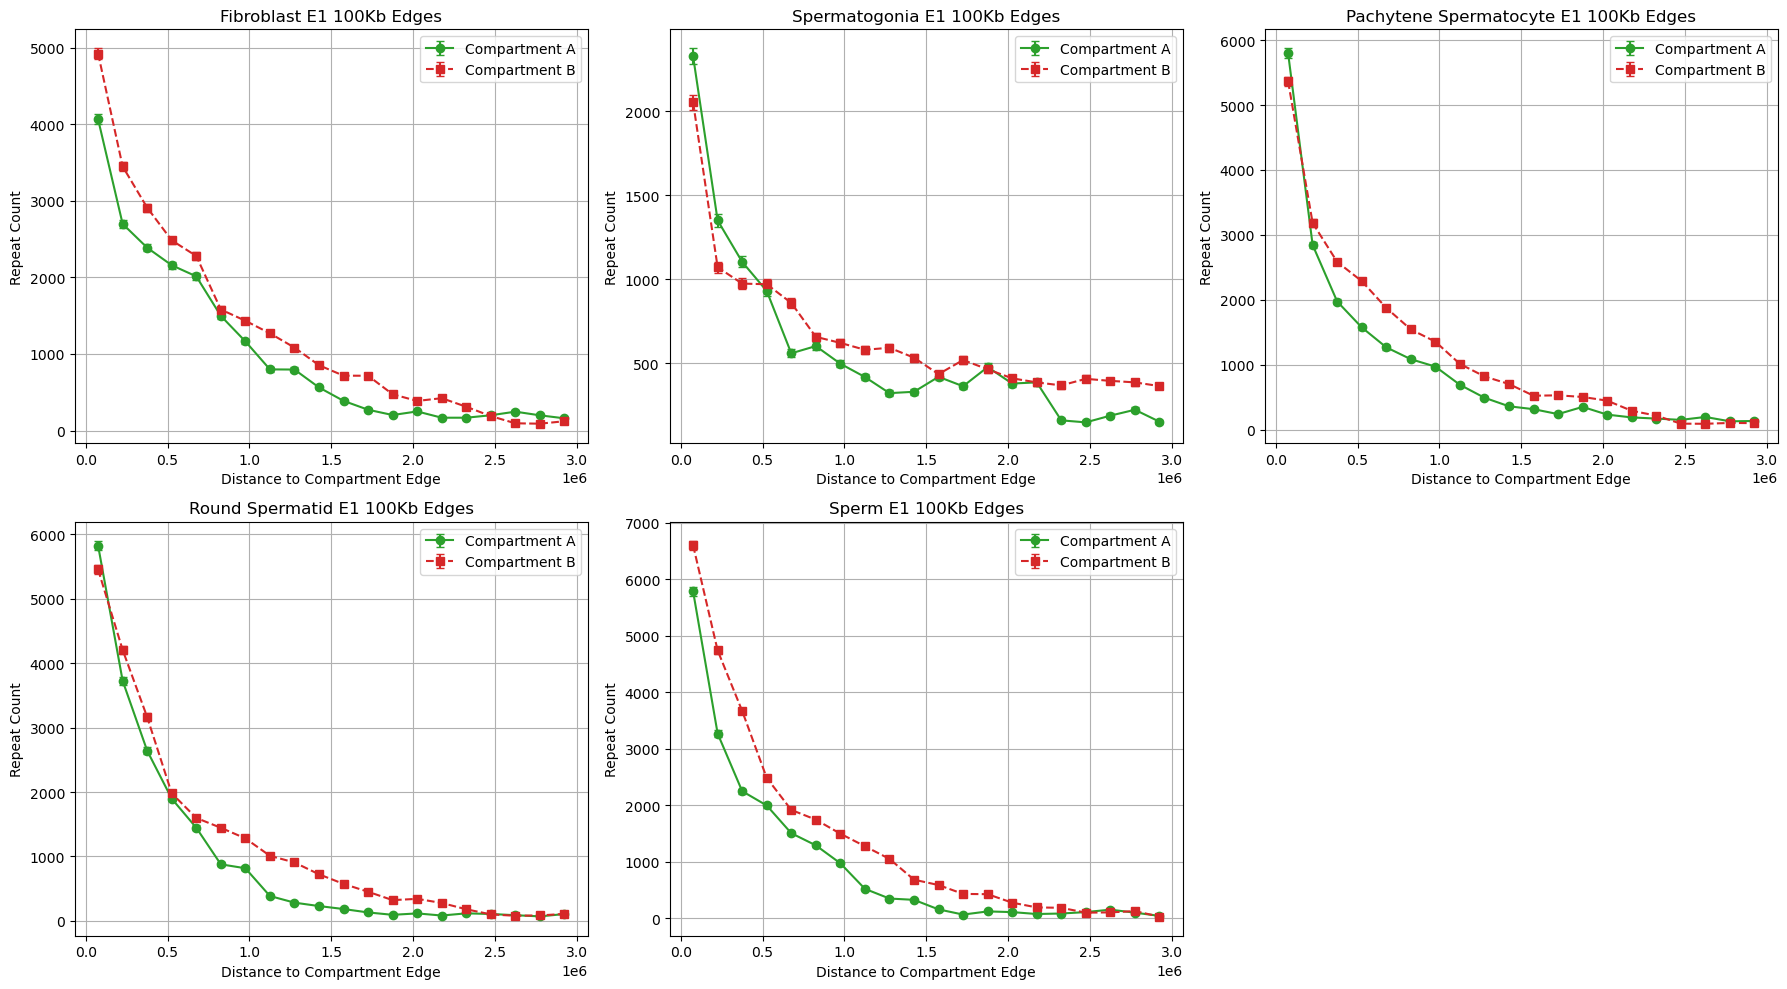

In [87]:
import numpy as np
import matplotlib.pyplot as plt

A_color = "#2CA02C"  # Green
B_color = "#D62728"  # Red

# Define the desired order for plotting
order = [
    "fibroblast_e1_100kb_edges",
    "spermatogonia_e1_100kb_edges",
    "pachytene_spermatocyte_e1_100kb_edges",
    "round_spermatid_e1_100kb_edges",
    "sperm_e1_100kb_edges",
]

# Plot settings
num_bins = 20
max_dist = 3_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def bin_absmid_with_error(absmid_values, bins):
    counts, _ = np.histogram(absmid_values, bins=bins)
    errors = np.sqrt(counts)
    return counts, errors

# Prepare plot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Loop through samples in the specified order
for idx, sample in enumerate(order):
    # Check if the sample exists in the data
    if sample not in remapped_simple_filter_data_chr8:
        print(f"Warning: {sample} not found in data, skipping...")
        continue
    
    pair = remapped_simple_filter_data_chr8[sample]
    A_df = pair["A"]
    B_df = pair["B"]

    # Bin 'absmid'
    counts_A, errors_A = bin_absmid_with_error(A_df['absmid'].dropna(), bins)
    counts_B, errors_B = bin_absmid_with_error(B_df['absmid'].dropna(), bins)

    ax = axes[idx]
    ax.errorbar(bin_centers, counts_A, yerr=errors_A, marker='o', linestyle='-', 
               capsize=3, label='Compartment A', color=A_color)
    ax.errorbar(bin_centers, counts_B, yerr=errors_B, marker='s', linestyle='--', 
               capsize=3, label='Compartment B', color=B_color)
    
    # Create a cleaner title by replacing underscores and capitalizing
    clean_title = sample.replace("_", " ").replace("e1 100kb edges AB", "").strip().title()
    ax.set_title(clean_title)
    ax.set_xlabel("Distance to Compartment Edge")
    ax.set_ylabel("Repeat Count")
    ax.grid(True)
    ax.legend()

# Hide unused subplots
for i in range(len(order), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig("/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/manuscript/illustrations/simple_repeat/simple_repeat_chr8_not_normalized.png", dpi=300)
plt.show()

[0.13043478 0.31521739 0.45652174 0.48913043 0.54347826 0.58695652
 0.61956522 0.70652174 0.7826087  0.79347826 0.84782609 0.84782609
 0.88043478 0.90217391 0.93478261 0.94565217 0.94565217 0.95652174
 1.         1.        ]
[12 17 13  3  5  4  3  8  7  1  5  0  3  2  3  1  0  1  4  0]
[92 80 63 50 47 42 38 35 27 20 19 14 14 11  9  6  5  5  4  0]

Sample: fibroblast_e1_100kb_edges
Counts A: [3054 2023 1687 1640 1445 1462 1390 1316  806  834  563  567  536  539
  285  297  199  164  147  131]
Counts B: [3486 2700 2187 1908 1870 1617 1597 1215 1049  995  833  876  740  591
  606  507  431  495  323  271]
Bin 1: 0–100000 bp | Count A = 3054, Count B = 3486, n_possible = 92
Bin 2: 100000–200000 bp | Count A = 2023, Count B = 2700, n_possible = 80
Bin 3: 200000–300000 bp | Count A = 1687, Count B = 2187, n_possible = 63
Bin 4: 300000–400000 bp | Count A = 1640, Count B = 1908, n_possible = 50
Bin 5: 400000–500000 bp | Count A = 1445, Count B = 1870, n_possible = 47
Bin 6: 500000–600000 bp |

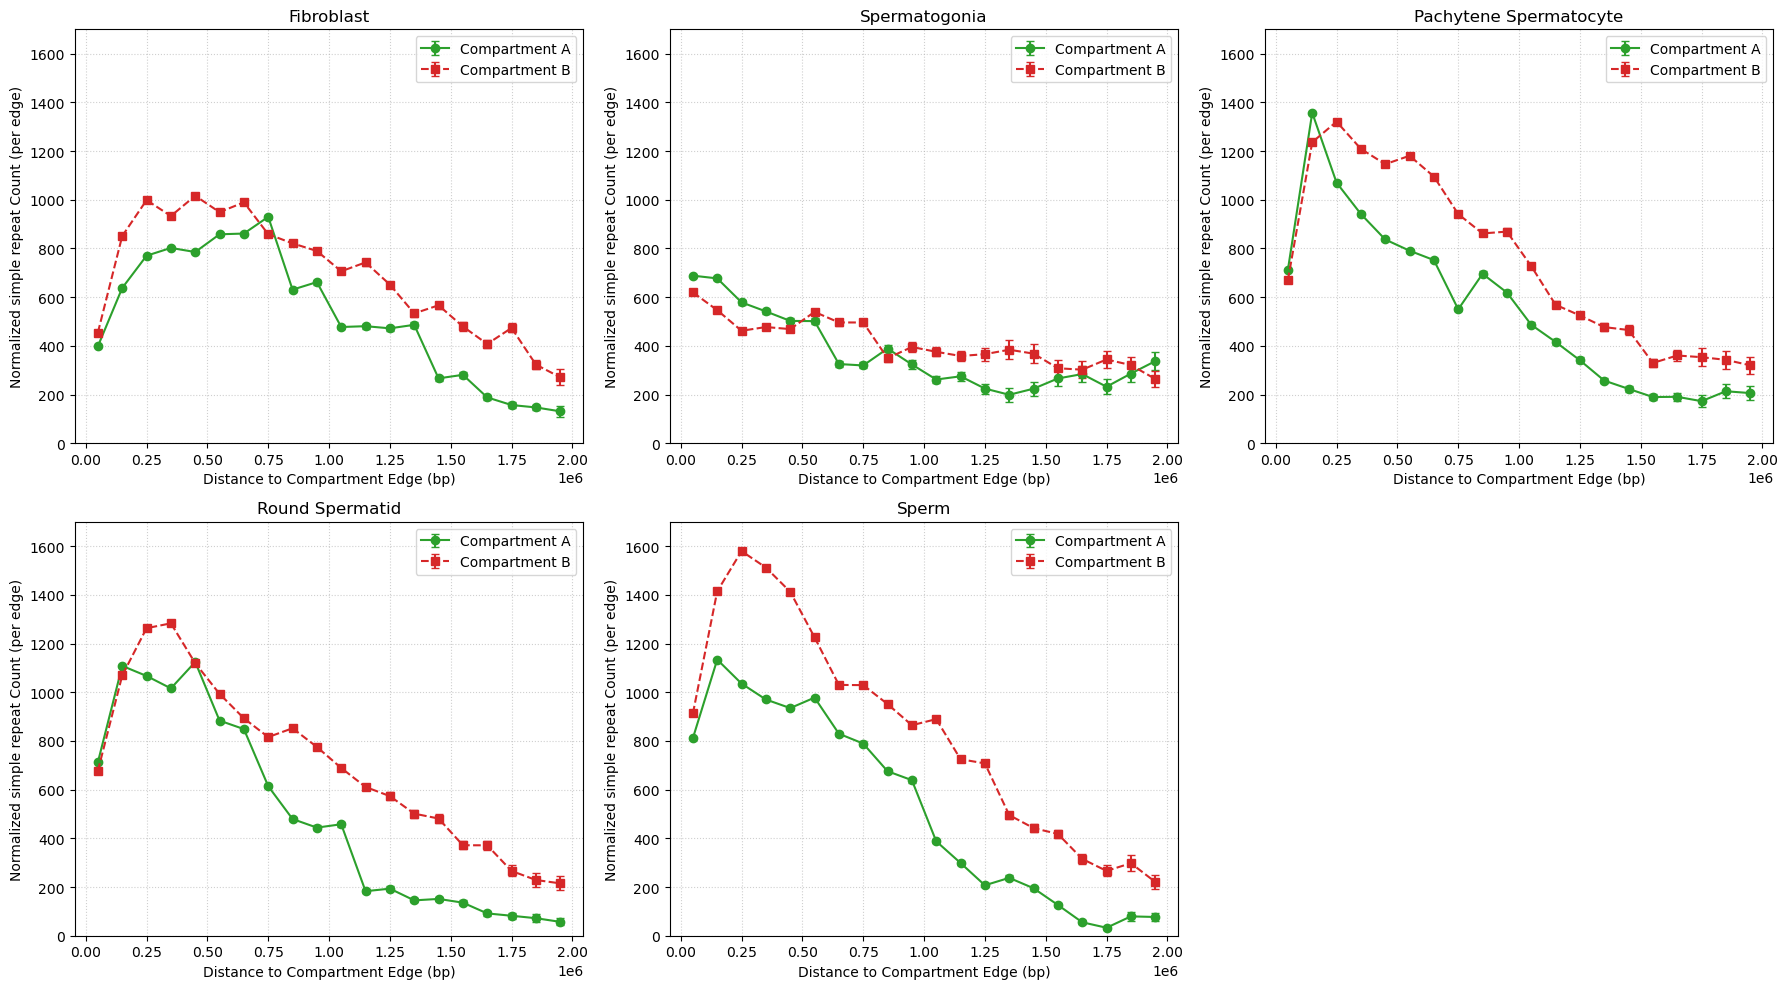

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats  # kept in case you switch CI method later

A_color = "#2CA02C"  # Green
B_color = "#D62728"  # Red

# Desired order
order = [
    "fibroblast_e1_100kb_edges",
    "spermatogonia_e1_100kb_edges",
    "pachytene_spermatocyte_e1_100kb_edges",
    "round_spermatid_e1_100kb_edges",
    "sperm_e1_100kb_edges",
]

# Plot settings
num_bins = 20
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def bin_half_distances_by_compartment(comp, max_dist=2_000_000, bins=num_bins):
    """
    Bin half-distances between consecutive 'start' positions (ignoring A/B),
    then compute forward and reverse cumulative fractions + reverse cumulative counts.
    """
    bin_edges = np.linspace(0, max_dist, bins + 1)

    start = comp['start'].values
    if len(start) < 2:
        counts = np.zeros(bins, dtype=int)
    else:
        half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]
        counts, _ = np.histogram(half_distances, bins=bin_edges)

    total = np.sum(counts)
    if total > 0:
        cumulative_fraction = np.cumsum(counts) / total
        reverse_cumulative_fraction = np.cumsum(counts[::-1])[::-1] / total
    else:
        cumulative_fraction = np.zeros(bins, dtype=float)
        reverse_cumulative_fraction = np.zeros(bins, dtype=float)

    reverse_cumulative = np.cumsum(counts[::-1])[::-1]  # n_possible per bin

    return {
        "counts": counts,
        "cumulative_fraction": cumulative_fraction,
        "reverse_cumulative_fraction": reverse_cumulative_fraction,
        "reverse_cumulative": reverse_cumulative
    }

# --- SD-based symmetric error bars using n_possible = reverse_cumulative ---
def bin_absmid_with_sd(absmid_values, bins, reverse_cumulative):
    """
    Returns:
      counts: (num_bins,)
      errors: (num_bins,) symmetric 95% CI ≈ 1.96 * sqrt(count / n_possible)
              where n_possible is reverse_cumulative (>=1).
    """
    counts, _ = np.histogram(absmid_values, bins=bins)

    n_possible = np.maximum(reverse_cumulative.astype(float), 1.0)
    with np.errstate(divide='ignore', invalid='ignore'):
        sd = np.sqrt(counts.astype(float) / n_possible)
        sd[np.isnan(sd)] = 0.0

    errors = 1.96 * sd  # 95% CI multiplier
    return counts, errors

# Prepare grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = np.array(axes).flatten()

plot_idx = 0
for sample in order:
    if sample not in remapped_simple_filter_data_chr8:
        print(f"⚠️ Warning: {sample} not found, skipping…")
        continue

    edge_key = f"{sample}_AB"
    if edge_key not in globals():
        print(f"⚠️ Warning: {edge_key} not found, skipping…")
        continue

    pair = remapped_simple_filter_data_chr8[sample]
    A_df = pair["A"]
    B_df = pair["B"]

    edge_df = globals()[edge_key]
    result = bin_half_distances_by_compartment(edge_df)

    # SD-based errors with n_possible from reverse_cumulative
    counts_A, errors_A = bin_absmid_with_sd(
        A_df['absmid'].dropna().values, bins, result["reverse_cumulative"]
    )
    counts_B, errors_B = bin_absmid_with_sd(
        B_df['absmid'].dropna().values, bins, result["reverse_cumulative"]
    )

    # Debug prints (fixed indentation)
    print(result["cumulative_fraction"])
    print(result["counts"])
    print(result["reverse_cumulative"])
    # 🔎 Print raw counts per bin (before normalization)
    print(f"\nSample: {sample}")
    print("Counts A:", counts_A)
    print("Counts B:", counts_B)
    for i in range(len(bins) - 1):
        print(f"Bin {i+1}: {bins[i]:.0f}–{bins[i+1]:.0f} bp | "
              f"Count A = {counts_A[i]}, Count B = {counts_B[i]}, "
              f"n_possible = {result['reverse_cumulative'][i]}")

    # Normalize counts (same transform applied to counts and errors)
    norm_cumulative = np.where(result["cumulative_fraction"] == 0,
                               np.nan, result["cumulative_fraction"])

    norm_counts_A = counts_A * norm_cumulative
    norm_counts_B = counts_B * norm_cumulative
    norm_errors_A = errors_A * norm_cumulative
    norm_errors_B = errors_B * norm_cumulative

    # Plot
    ax = axes[plot_idx]
    ax.errorbar(bin_centers, norm_counts_A, yerr=norm_errors_A, marker='o',
                linestyle='-', capsize=3, label='Compartment A', color=A_color)
    ax.errorbar(bin_centers, norm_counts_B, yerr=norm_errors_B, marker='s',
                linestyle='--', capsize=3, label='Compartment B', color=B_color)

    clean_title = sample.replace("_e1_100kb_edges", "").replace("_", " ").title()
    ax.set_title(clean_title)
    ax.set_xlabel("Distance to Compartment Edge (bp)")
    ax.set_ylabel("Normalized simple repeat Count (per edge)")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend()
    ax.set_ylim(0, 1700)

    plot_idx += 1

# Hide unused panels
for i in range(plot_idx, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.savefig(
    "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/manuscript/illustrations/simple_repeat/simple_repeat_chr8_normalized_poisson_CI.png",
    dpi=300
)
plt.show()


# ab ir BA

In [89]:
# Explicit list of (name, DataFrame) tuples
input_list = [
    ("fibroblast_e1_100kb_edges_AB", fibroblast_e1_100kb_edges_AB),
    ("pachytene_spermatocyte_e1_100kb_edges_AB", pachytene_spermatocyte_e1_100kb_edges_AB),
    ("round_spermatid_e1_100kb_edges_AB", round_spermatid_e1_100kb_edges_AB),
    ("spermatogonia_e1_100kb_edges_AB", spermatogonia_e1_100kb_edges_AB),
    ("sperm_e1_100kb_edges_AB", sperm_e1_100kb_edges_AB),
]

# Dictionary for storing results
remapped_data_chr8 = {}

# Loop and run the function
for name, df_anchor in input_list:
    print(f"\nRunning on: {name}")
    try:
        A_value, B_value = remapping_no_filter_compartment(df_simple_repeats_chr8, df_anchor)

        remapped_data_chr8[name.replace('_AB', '')] = {
            "A": A_value,
            "B": B_value
        }

        print(f"  A_value: {A_value.shape}, B_value: {B_value.shape}")
    except Exception as e:
        print(f"  ❌ Failed on {name}: {e}")



Running on: fibroblast_e1_100kb_edges_AB


  A_value: (23714, 12), B_value: (23939, 12)

Running on: pachytene_spermatocyte_e1_100kb_edges_AB
  A_value: (21631, 12), B_value: (21760, 12)

Running on: round_spermatid_e1_100kb_edges_AB
  A_value: (22122, 12), B_value: (21932, 12)

Running on: spermatogonia_e1_100kb_edges_AB
  A_value: (18763, 12), B_value: (18518, 12)

Running on: sperm_e1_100kb_edges_AB
  A_value: (23823, 12), B_value: (23510, 12)


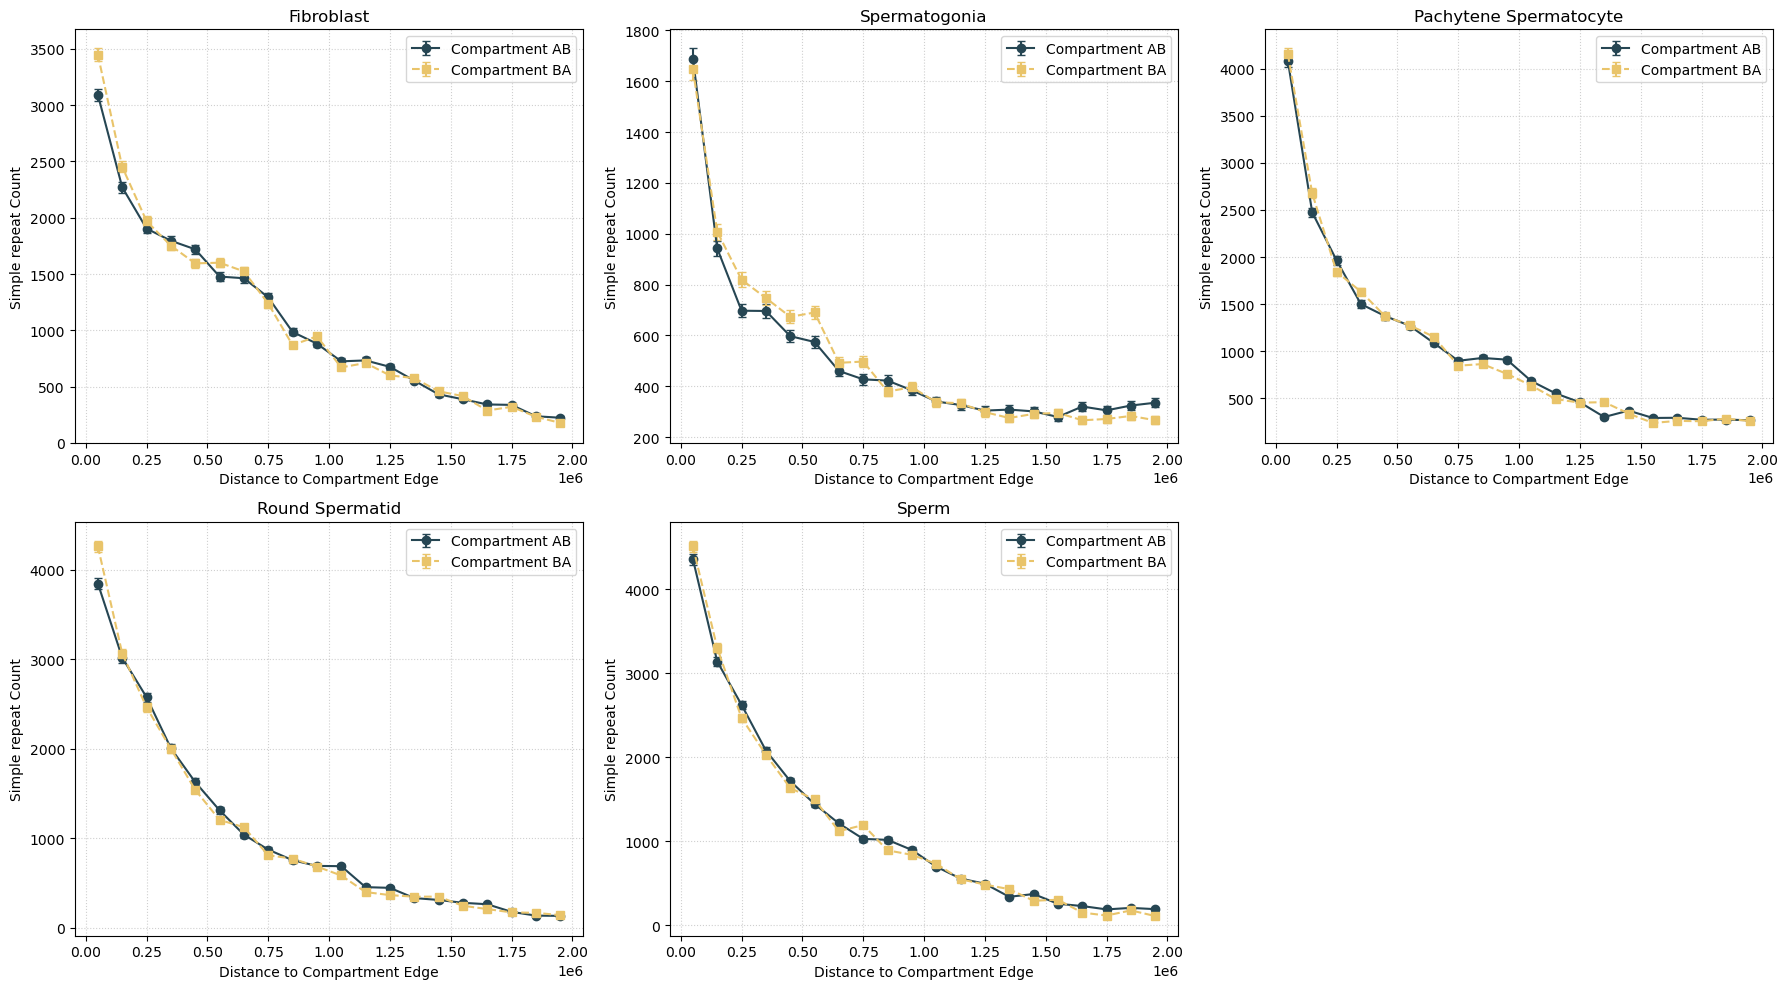

In [90]:
import numpy as np
import matplotlib.pyplot as plt

A_color = "#264653"  # Indigo
B_color = "#E9C46A"  # Coral

# Desired order
order = [
    "fibroblast_e1_100kb_edges",
    "spermatogonia_e1_100kb_edges",
    "pachytene_spermatocyte_e1_100kb_edges",
    "round_spermatid_e1_100kb_edges",
    "sperm_e1_100kb_edges",
]

# Plot settings
num_bins = 20
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def bin_absmid_with_error(absmid_values, bins):
    counts, _ = np.histogram(absmid_values, bins=bins)
    errors = np.sqrt(np.maximum(counts, 1))  # avoid zero-length errorbars
    return counts, errors

# Use a 2x3 grid (fits up to 6 plots)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = np.array(axes).flatten()

# Only plot samples that exist
present = [s for s in order if s in remapped_data_chr8]

plot_idx = 0
for sample in present:
    if plot_idx >= len(axes):
        break  # safety if more samples than axes

    pair = remapped_data_chr8[sample]
    A_df = pair["A"]
    B_df = pair["B"]

    counts_A, errors_A = bin_absmid_with_error(A_df['absmid'].dropna().values, bins)
    counts_B, errors_B = bin_absmid_with_error(B_df['absmid'].dropna().values, bins)

    ax = axes[plot_idx]
    ax.errorbar(bin_centers, counts_A, yerr=errors_A, marker='o', linestyle='-',
                capsize=3, label='Compartment AB', color=A_color)
    ax.errorbar(bin_centers, counts_B, yerr=errors_B, marker='s', linestyle='--',
                capsize=3, label='Compartment BA', color=B_color)

    # Clean title (strip common suffix and prettify)
    clean_title = (sample
                   .replace("_e1_100kb_edges", "")
                   .replace("_", " ")
                   .title())
    ax.set_title(clean_title)
    ax.set_xlabel("Distance to Compartment Edge")
    ax.set_ylabel("Simple repeat Count")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend()

    plot_idx += 1

# Hide any unused subplots
for i in range(plot_idx, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


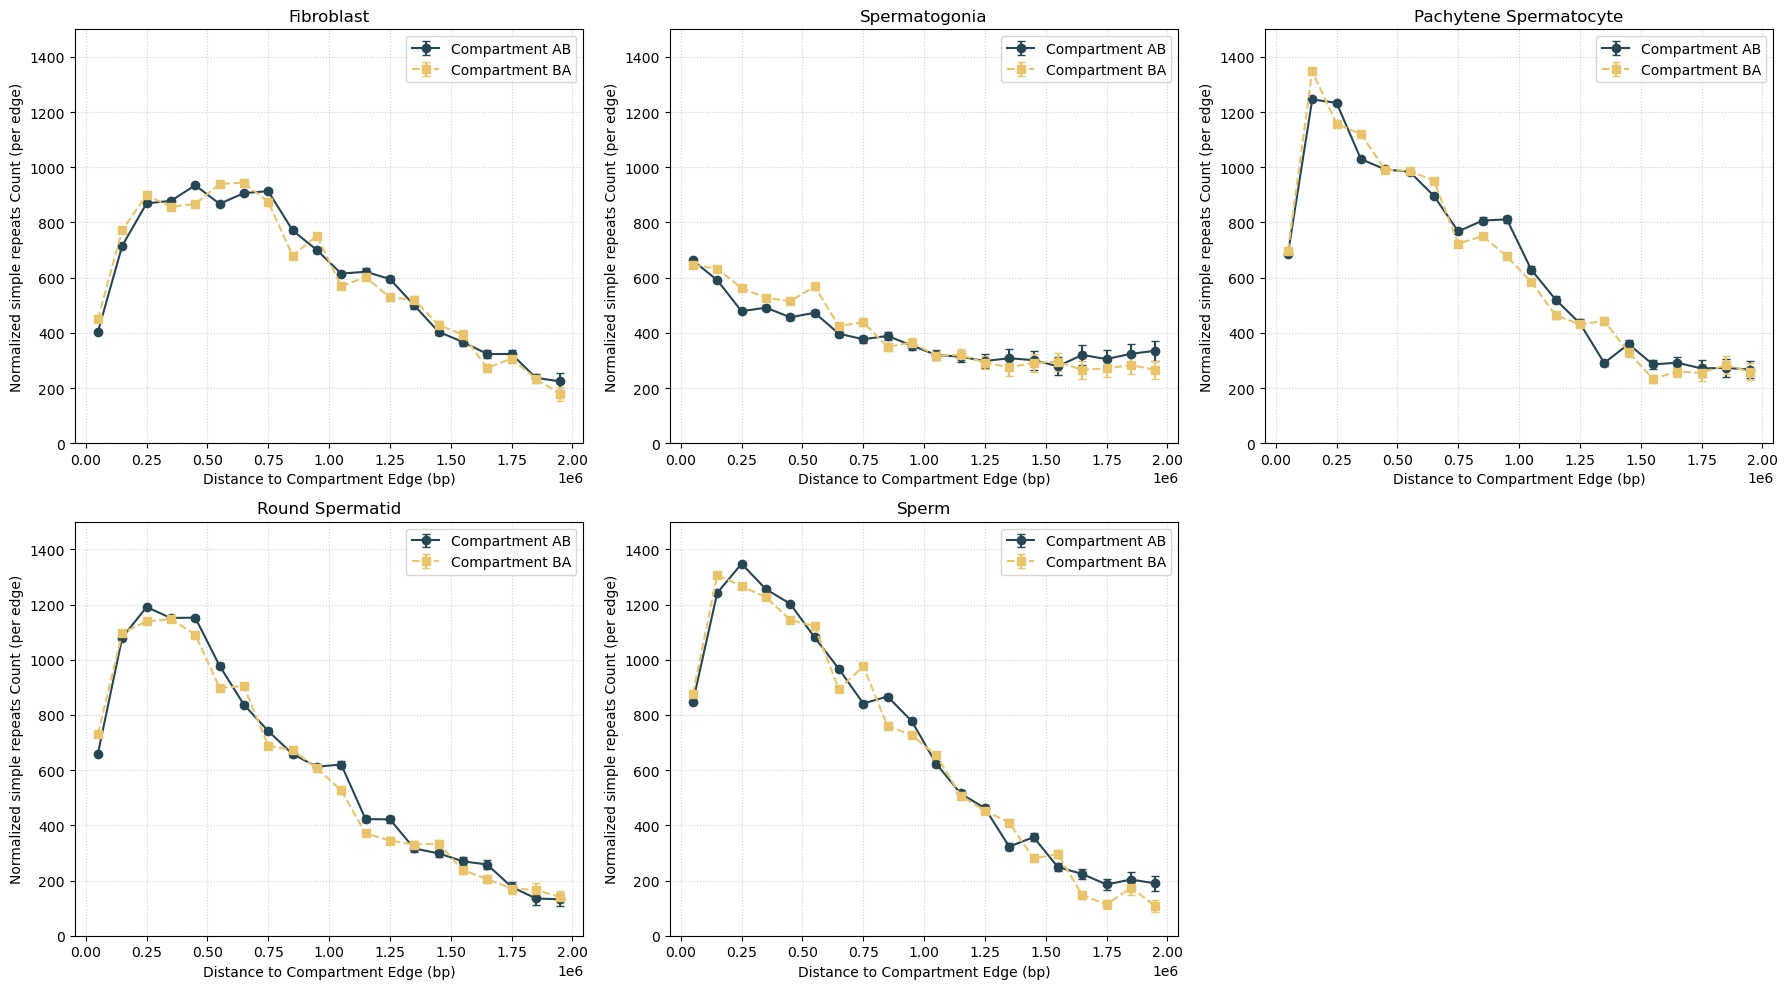

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats  # kept in case you switch CI method later

A_color = "#264653"  # Indigo
B_color = "#E9C46A"  # Coral

# Desired order (match keys in remapped_data)
order = [
    "fibroblast_e1_100kb_edges",
    "spermatogonia_e1_100kb_edges",
    "pachytene_spermatocyte_e1_100kb_edges",
    "round_spermatid_e1_100kb_edges",
    "sperm_e1_100kb_edges",
]

# Plot settings — match the “correct plot”
num_bins = 20
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def bin_half_distances_ignoring_comp(comp, max_dist=2_000_000, bins=num_bins):
    """
    Bin half-distances between consecutive 'start' positions (ignoring A/B),
    then compute forward and reverse cumulative fractions + reverse cumulative counts.
    """
    bin_edges = np.linspace(0, max_dist, bins + 1)

    start = comp['start'].values
    if len(start) < 2:
        counts = np.zeros(bins, dtype=int)
    else:
        half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]
        counts, _ = np.histogram(half_distances, bins=bin_edges)

    total = np.sum(counts)
    if total > 0:
        cumulative_fraction = np.cumsum(counts) / total
        reverse_cumulative_fraction = np.cumsum(counts[::-1])[::-1] / total
    else:
        cumulative_fraction = np.zeros(bins, dtype=float)
        reverse_cumulative_fraction = np.zeros(bins, dtype=float)

    reverse_cumulative = np.cumsum(counts[::-1])[::-1]  # n_possible per bin

    return {
        "counts": counts,
        "cumulative_fraction": cumulative_fraction,
        "reverse_cumulative_fraction": reverse_cumulative_fraction,
        "reverse_cumulative": reverse_cumulative
    }

# --- SD-based symmetric error bars using n_possible = reverse_cumulative (same as your correct plot) ---
def bin_absmid_with_sd(absmid_values, bins, reverse_cumulative):
    """
    Returns:
      counts: (num_bins,)
      errors: (num_bins,) symmetric 95% CI ≈ 1.96 * sqrt(count / n_possible)
              where n_possible is reverse_cumulative (>=1).
    """
    counts, _ = np.histogram(absmid_values, bins=bins)
    n_possible = np.maximum(reverse_cumulative.astype(float), 1.0)
    with np.errstate(divide='ignore', invalid='ignore'):
        sd = np.sqrt(counts.astype(float) / n_possible)
        sd[np.isnan(sd)] = 0.0
    errors = 1.96 * sd  # 95% CI multiplier
    return counts, errors

# Grid (2x3 fits up to 6 plots)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = np.array(axes).flatten()

plot_idx = 0
for sample in order:
    if sample not in remapped_data_chr8:
        print(f"Warning: {sample} not found in remapped_data, skipping...")
        continue

    edge_key = f"{sample}_AB"
    if edge_key not in globals():
        print(f"Warning: {edge_key} not found in globals(), skipping...")
        continue

    if plot_idx >= len(axes):
        break  # safety if more samples than axes

    pair = remapped_data_chr8[sample]
    A_df = pair["A"]
    B_df = pair["B"]

    # Edge distances pooled (ignore A/B) to get n_possible and cumulative fractions
    edge_df = globals()[edge_key]
    result = bin_half_distances_ignoring_comp(edge_df)

    # Counts + SD-based symmetric CI using reverse_cumulative as n_possible
    counts_A, errors_A = bin_absmid_with_sd(
        A_df['absmid'].dropna().values, bins, result["reverse_cumulative"]
    )
    counts_B, errors_B = bin_absmid_with_sd(
        B_df['absmid'].dropna().values, bins, result["reverse_cumulative"]
    )

    # Normalize by the same cumulative fraction for both (from pooled edges)
    norm_cumulative = np.where(result["cumulative_fraction"] == 0,
                               np.nan, result["cumulative_fraction"])

    norm_counts_A = counts_A * norm_cumulative
    norm_counts_B = counts_B * norm_cumulative
    norm_errors_A = errors_A * norm_cumulative
    norm_errors_B = errors_B * norm_cumulative

    ax = axes[plot_idx]
    ax.errorbar(
        bin_centers, norm_counts_A, yerr=norm_errors_A,
        marker='o', linestyle='-', capsize=3, label='Compartment AB', color=A_color
    )
    ax.errorbar(
        bin_centers, norm_counts_B, yerr=norm_errors_B,
        marker='s', linestyle='--', capsize=3, label='Compartment BA', color=B_color
    )

    clean_title = sample.replace("_e1_100kb_edges", "").replace("_", " ").title()
    ax.set_title(clean_title)
    ax.set_xlabel("Distance to Compartment Edge (bp)")
    ax.set_ylabel("Normalized simple repeats Count (per edge)")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend()
    ax.set_ylim(0, 1500)  # match your correct plot

    plot_idx += 1

# Hide any unused subplots
for i in range(plot_idx, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(
    "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/manuscript/illustrations/simple_repeat/simple_repeat_chr8_normalized_sd_CI_AB_BA.png",
    dpi=300
)
plt.show()

## combined plot

chr8 keys (normalized): ['fibroblast_e1_100kb_edges', 'pachytene_spermatocyte_e1_100kb_edges', 'round_spermatid_e1_100kb_edges', 'sperm_e1_100kb_edges', 'spermatogonia_e1_100kb_edges']
chrx keys (normalized): ['fibroblast_e1_100kb_edges', 'pachytene_spermatocyte_e1_100kb_edges', 'round_spermatid_e1_100kb_edges', 'sperm_e1_100kb_edges', 'spermatogonia_e1_100kb_edges']


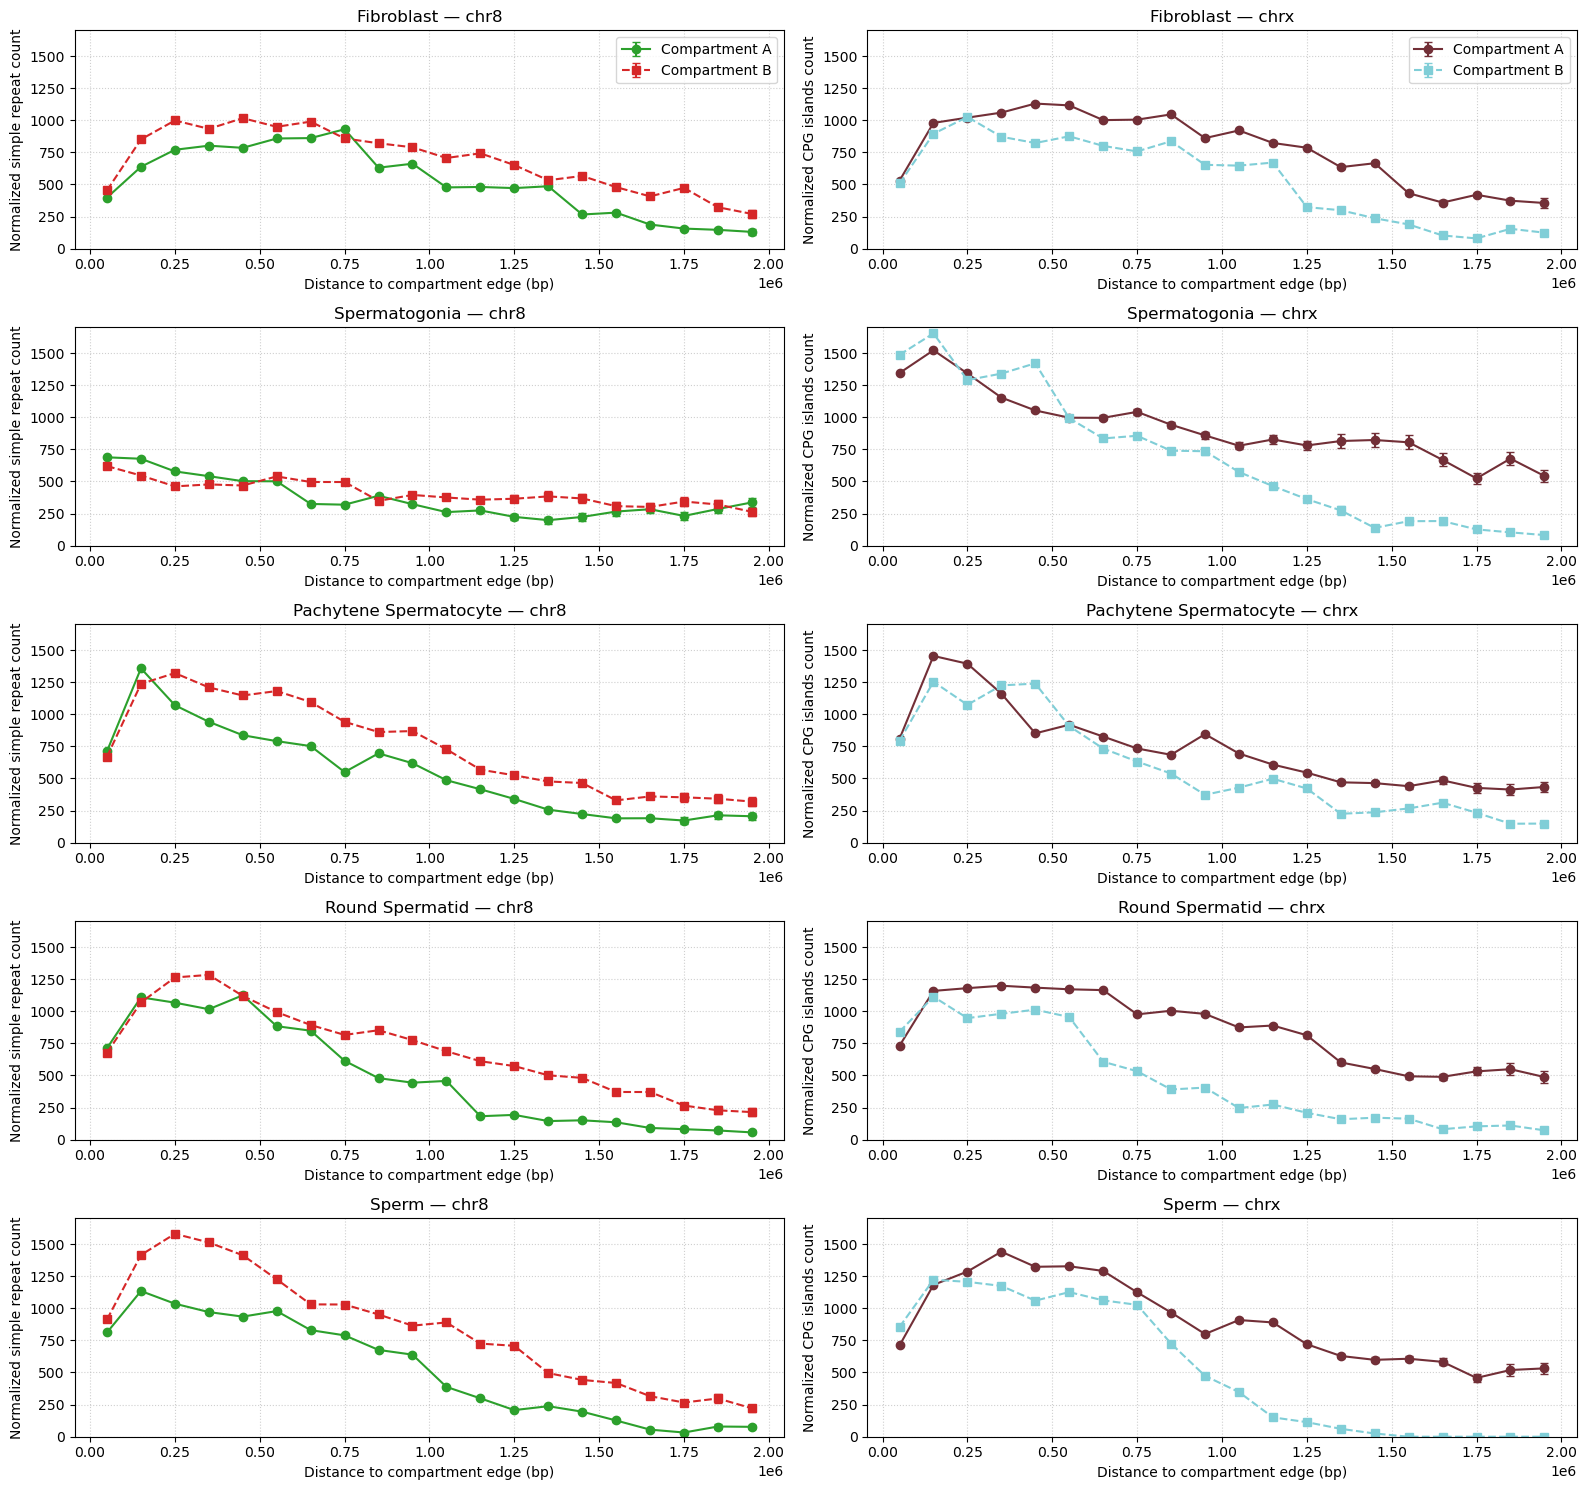

In [98]:
import re
import numpy as np
import matplotlib.pyplot as plt

# ===================== CONFIG =====================

# Base order WITHOUT _10Mb
base_order = [
    "fibroblast_e1_100kb_edges",
    "spermatogonia_e1_100kb_edges",
    "pachytene_spermatocyte_e1_100kb_edges",
    "round_spermatid_e1_100kb_edges",
    "sperm_e1_100kb_edges",
]

# Binning / axes
num_bins = 20
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Colors: chr8 vs chrx
chr8_colors = {"A": "#2CA02C", "B": "#D62728"}   # Green / Red
chrx_colors = {"A": "#722F37", "B": "#80CED7"}   # Indigo / Coral

# ===================== HELPERS =====================

def normalize_key(name: str) -> str:
    """Drop trailing _AB and optional _10Mb before _edges, to match base_order."""
    k = re.sub(r'_AB$', '', name)
    k = re.sub(r'_10Mb(?=_edges)', '', k)
    return k

def normalize_dict_keys(d: dict) -> dict:
    """Return a view of d with normalized keys."""
    return {normalize_key(k): v for k, v in d.items()}

def resolve_edge_df(sample_base: str):
    """
    Return the edge DataFrame for the sample, trying both:
      <sample_base>_AB
      <sample_base with _10Mb before _edges>_AB
    """
    direct = f"{sample_base}_AB"
    if direct in globals():
        return globals()[direct], direct

    sample_10mb = re.sub(r'(_e1_100kb)(?=_edges$)', r'\1_10Mb', sample_base)
    alt = f"{sample_10mb}_AB"
    if alt in globals():
        return globals()[alt], alt

    return None, None

# --------- Your original analytics helpers (kept intact) ---------

def bin_half_distances_by_compartment(comp, max_dist=2_000_000, bins=num_bins):
    """
    Bin half-distances between consecutive 'start' positions (ignoring A/B),
    then compute forward/reverse cumulative fractions + reverse cumulative counts.
    """
    bin_edges = np.linspace(0, max_dist, bins + 1)

    start = comp['start'].values
    if len(start) < 2:
        counts = np.zeros(bins, dtype=int)
    else:
        half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]
        counts, _ = np.histogram(half_distances, bins=bin_edges)

    total = np.sum(counts)
    if total > 0:
        cumulative_fraction = np.cumsum(counts) / total
        reverse_cumulative_fraction = np.cumsum(counts[::-1])[::-1] / total
    else:
        cumulative_fraction = np.zeros(bins, dtype=float)
        reverse_cumulative_fraction = np.zeros(bins, dtype=float)

    reverse_cumulative = np.cumsum(counts[::-1])[::-1]  # n_possible per bin

    return {
        "counts": counts,
        "cumulative_fraction": cumulative_fraction,
        "reverse_cumulative_fraction": reverse_cumulative_fraction,
        "reverse_cumulative": reverse_cumulative
    }

def bin_absmid_with_sd(absmid_values, bins, reverse_cumulative):
    """
    Returns:
      counts: (num_bins,)
      errors: (num_bins,) symmetric 95% CI ≈ 1.96 * sqrt(count / n_possible)
              where n_possible is reverse_cumulative (>=1).
    """
    counts, _ = np.histogram(absmid_values, bins=bins)

    n_possible = np.maximum(reverse_cumulative.astype(float), 1.0)
    with np.errstate(divide='ignore', invalid='ignore'):
        sd = np.sqrt(counts.astype(float) / n_possible)
        sd[np.isnan(sd)] = 0.0

    errors = 1.96 * sd  # 95% CI multiplier
    return counts, errors

def compute_norm_counts(dict_data, sample_base):
    """
    Compute normalized counts/errors for A/B for a given dictionary and base key.
    Returns (nA, nB, eA, eB) or (None, error_string).
    """
    if sample_base not in dict_data:
        return None, f"{sample_base} not in dictionary"

    pair = dict_data[sample_base]
    A_df, B_df = pair["A"], pair["B"]

    edge_df, edge_name = resolve_edge_df(sample_base)
    if edge_df is None:
        return None, f"edge DF not found for {sample_base} (tried _AB & _10Mb_AB)"

    result = bin_half_distances_by_compartment(edge_df, max_dist=max_dist, bins=num_bins)
    counts_A, errors_A = bin_absmid_with_sd(A_df['absmid'].dropna().values, bins, result["reverse_cumulative"])
    counts_B, errors_B = bin_absmid_with_sd(B_df['absmid'].dropna().values, bins, result["reverse_cumulative"])

    norm_cum = np.where(result["cumulative_fraction"] == 0, np.nan, result["cumulative_fraction"])
    nA = counts_A * norm_cum
    nB = counts_B * norm_cum
    eA = errors_A * norm_cum
    eB = errors_B * norm_cum
    return (nA, nB, eA, eB), None

# ===================== INPUT DICTS =====================
# Expect these two variables to already exist and be filled as:
# remapped_simple_filter_data_chr8[sample_base] = {"A": df, "B": df}
# remapped_simple_filter_data_chrx[sample_base or sample_10Mb] = {"A": df, "B": df}

# Normalize both dicts to base keys
remapped_chr8 = normalize_dict_keys(remapped_simple_filter_data_chr8)
remapped_chrx = normalize_dict_keys(remapped_simple_filter_data_chrx)

# Optional: sanity prints
print("chr8 keys (normalized):", sorted(remapped_chr8.keys()))
print("chrx keys (normalized):", sorted(remapped_chrx.keys()))

# ===================== PLOTTING =====================

nrows = len(base_order)
fig, axes = plt.subplots(nrows, 2, figsize=(16, 3.0*nrows), sharex=False, sharey=False)
if nrows == 1:
    axes = np.array([axes])

for r, sample in enumerate(base_order):
    clean = sample.replace("_e1_100kb_edges", "").replace("_", " ").title()

    # ----- Left column: chr8 -----
    ax = axes[r, 0]
    res, err = compute_norm_counts(remapped_chr8, sample)
    if err:
        ax.text(0.5, 0.5, f"{sample}\n(chr8: {err})",
                ha="center", va="center", transform=ax.transAxes)
        ax.axis("off")
    else:
        nA, nB, eA, eB = res
        ax.errorbar(bin_centers, nA, yerr=eA, marker='o', linestyle='-', capsize=3,
                    label='Compartment A', color=chr8_colors["A"])
        ax.errorbar(bin_centers, nB, yerr=eB, marker='s', linestyle='--', capsize=3,
                    label='Compartment B', color=chr8_colors["B"])
        ax.set_title(f"{clean} — chr8")
        ax.grid(True, linestyle=":", alpha=0.6)
        if r == 0:
            ax.legend()

    # Always show x/y labels
    ax.set_xlabel("Distance to compartment edge (bp)")
    ax.set_ylabel("Normalized simple repeat count")

    # ----- Right column: chrx -----
    ax = axes[r, 1]
    res, err = compute_norm_counts(remapped_chrx, sample)
    if err:
        ax.text(0.5, 0.5, f"{sample}\n(chrx: {err})",
                ha="center", va="center", transform=ax.transAxes)
        ax.axis("off")
    else:
        nA, nB, eA, eB = res
        ax.errorbar(bin_centers, nA, yerr=eA, marker='o', linestyle='-', capsize=3,
                    label='Compartment A', color=chrx_colors["A"])
        ax.errorbar(bin_centers, nB, yerr=eB, marker='s', linestyle='--', capsize=3,
                    label='Compartment B', color=chrx_colors["B"])
        ax.set_title(f"{clean} — chrx")
        ax.grid(True, linestyle=":", alpha=0.6)
        if r == 0:
            ax.legend()

    # Always show x/y labels
    ax.set_xlabel("Distance to compartment edge (bp)")
    ax.set_ylabel("Normalized CPG islands count")

# Adjust Y-limits for visibility (optional)
for ax in axes.ravel():
    if ax.has_data():
        ax.set_ylim(0, 1700)  # tweak as needed

plt.tight_layout()
plt.savefig(
    "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/manuscript/illustrations/simple_repeat/simple_repeat_chr8_vs_chrx_normalized_poisson_CI_allaxes.png",
    dpi=300
)
plt.show()


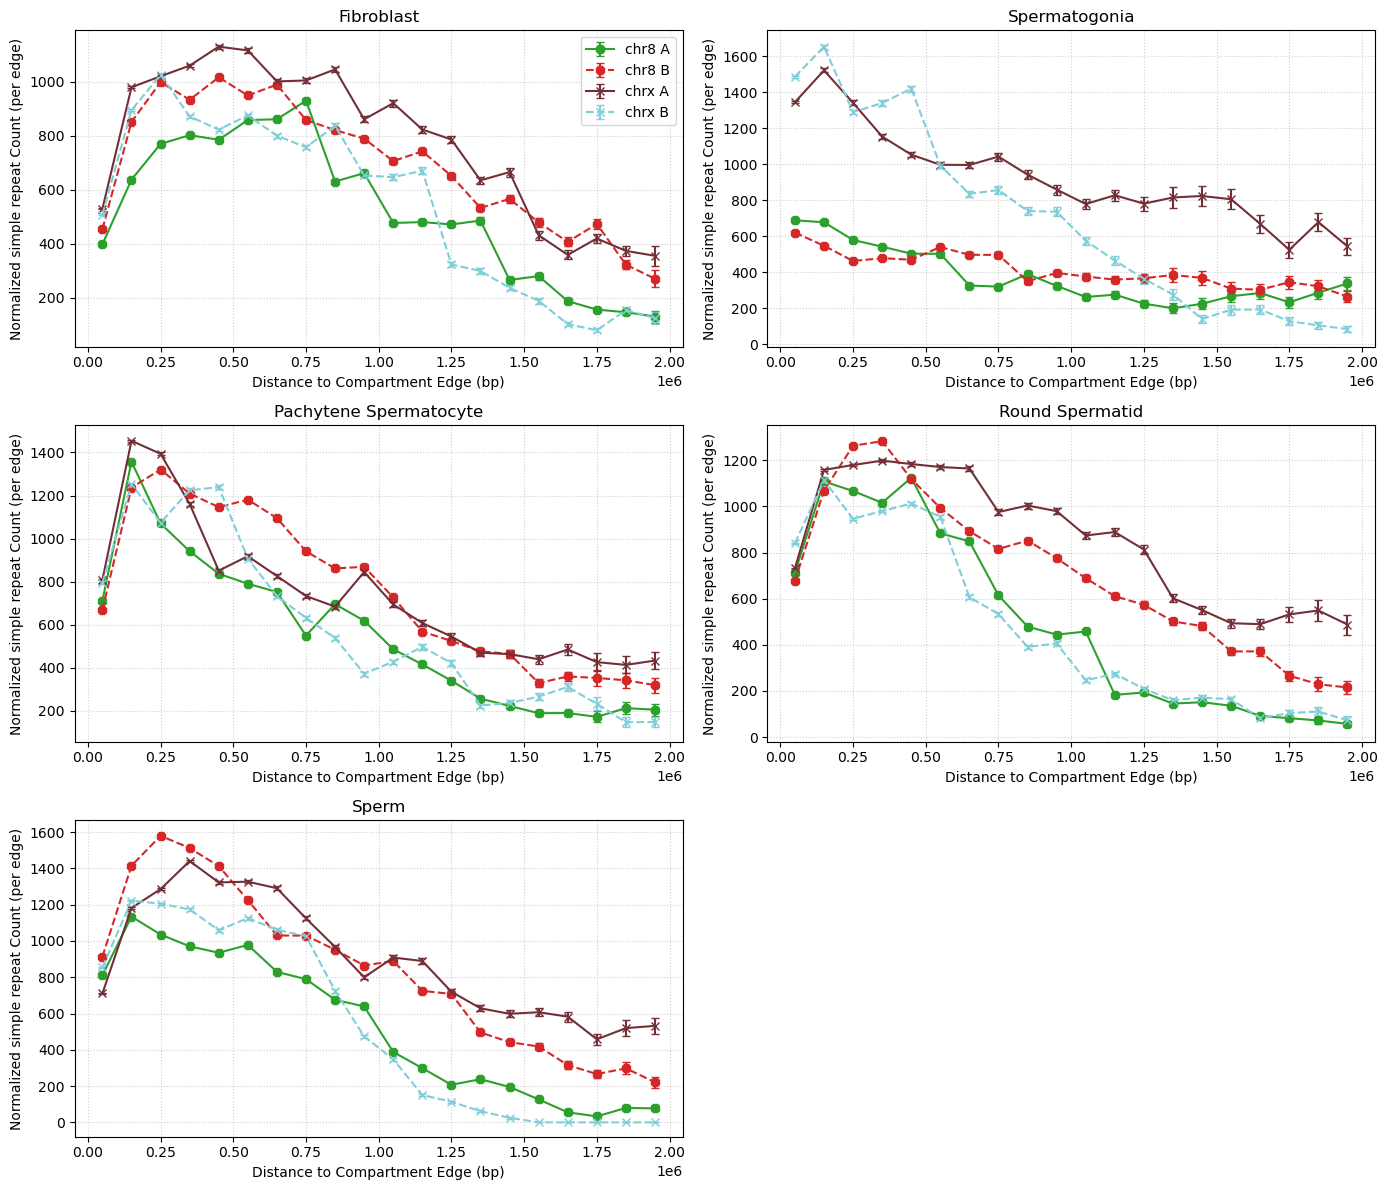

In [93]:
import re
import numpy as np
import matplotlib.pyplot as plt

# ===================== CONFIG =====================

base_order = [
    "fibroblast_e1_100kb_edges",
    "spermatogonia_e1_100kb_edges",
    "pachytene_spermatocyte_e1_100kb_edges",
    "round_spermatid_e1_100kb_edges",
    "sperm_e1_100kb_edges",
]

num_bins = 20
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Colors: chr8 vs chrx
chr8_colors = {"A": "#2CA02C", "B": "#D62728"}   # Green / Red
chrx_colors = {"A": "#722F37", "B": "#80CED7"}   # Indigo / Coral

# ===================== HELPERS =====================

def normalize_key(name: str) -> str:
    k = re.sub(r'_AB$', '', name)
    k = re.sub(r'_10Mb(?=_edges)', '', k)
    return k

def normalize_dict_keys(d: dict) -> dict:
    return {normalize_key(k): v for k, v in d.items()}

def resolve_edge_df(sample_base: str):
    direct = f"{sample_base}_AB"
    if direct in globals():
        return globals()[direct]
    sample_10mb = re.sub(r'(_e1_100kb)(?=_edges$)', r'\1_10Mb', sample_base)
    alt = f"{sample_10mb}_AB"
    if alt in globals():
        return globals()[alt]
    return None

def bin_half_distances_by_compartment(comp, max_dist=2_000_000, bins=num_bins):
    bin_edges = np.linspace(0, max_dist, bins + 1)
    start = comp['start'].values
    if len(start) < 2:
        counts = np.zeros(bins, dtype=int)
    else:
        half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]
        counts, _ = np.histogram(half_distances, bins=bin_edges)

    total = np.sum(counts)
    if total > 0:
        cumulative_fraction = np.cumsum(counts) / total
    else:
        cumulative_fraction = np.zeros(bins, dtype=float)

    reverse_cumulative = np.cumsum(counts[::-1])[::-1]
    return {"cumulative_fraction": cumulative_fraction, "reverse_cumulative": reverse_cumulative}

def bin_absmid_with_sd(absmid_values, bins, reverse_cumulative):
    counts, _ = np.histogram(absmid_values, bins=bins)
    n_possible = np.maximum(reverse_cumulative.astype(float), 1.0)
    sd = np.sqrt(counts.astype(float) / n_possible)
    errors = 1.96 * np.nan_to_num(sd)  # 95% CI
    return counts, errors

def compute_norm_counts(dict_data, sample_base):
    if sample_base not in dict_data:
        return None
    pair = dict_data[sample_base]
    A_df, B_df = pair["A"], pair["B"]
    edge_df = resolve_edge_df(sample_base)
    if edge_df is None:
        return None

    result = bin_half_distances_by_compartment(edge_df, max_dist=max_dist, bins=num_bins)
    counts_A, errors_A = bin_absmid_with_sd(A_df['absmid'].dropna().values, bins, result["reverse_cumulative"])
    counts_B, errors_B = bin_absmid_with_sd(B_df['absmid'].dropna().values, bins, result["reverse_cumulative"])

    norm_cum = np.where(result["cumulative_fraction"] == 0, np.nan, result["cumulative_fraction"])
    nA = counts_A * norm_cum
    nB = counts_B * norm_cum
    eA = errors_A * norm_cum
    eB = errors_B * norm_cum
    return (nA, nB, eA, eB)

# ===================== NORMALIZE INPUTS =====================
remapped_chr8 = normalize_dict_keys(remapped_simple_filter_data_chr8)
remapped_chrx = normalize_dict_keys(remapped_simple_filter_data_chrx)

# ===================== PLOT =====================
nplots = len(base_order)
nrows, ncols = 3, 2

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 12))
axes = axes.flatten()

for idx, sample in enumerate(base_order):
    ax = axes[idx]
    clean = sample.replace("_e1_100kb_edges", "").replace("_", " ").title()

    res8 = compute_norm_counts(remapped_chr8, sample)
    resx = compute_norm_counts(remapped_chrx, sample)

    if res8:
        nA, nB, eA, eB = res8
        ax.errorbar(bin_centers, nA, yerr=eA, marker='8', linestyle='-', 
                    capsize=3, label='chr8 A', color=chr8_colors["A"])
        ax.errorbar(bin_centers, nB, yerr=eB, marker='8', linestyle='--', 
                    capsize=3, label='chr8 B', color=chr8_colors["B"])
    if resx:
        nA, nB, eA, eB = resx
        ax.errorbar(bin_centers, nA, yerr=eA, marker='x', linestyle='-', 
                    capsize=3, label='chrx A', color=chrx_colors["A"])
        ax.errorbar(bin_centers, nB, yerr=eB, marker='x', linestyle='--', 
                    capsize=3, label='chrx B', color=chrx_colors["B"])

    ax.set_title(clean)
    ax.set_xlabel("Distance to Compartment Edge (bp)")
    ax.set_ylabel("Normalized simple repeat Count (per edge)")
    ax.grid(True, linestyle=":", alpha=0.6)
    if idx == 0:
        ax.legend()

# Hide unused subplot if any
for j in range(nplots, nrows*ncols):
    axes[j].axis("off")

plt.tight_layout()
plt.savefig(
    "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/manuscript/illustrations/simple_repeat/simple_repeat_chr8_plus_chrx_overlay_grid3x2_allaxes.png",
    dpi=300
)
plt.show()

